<a href="https://colab.research.google.com/github/luisERH/Analise-de-Twitters/blob/master/OCR_ORGANIZADO(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
! pip install --upgrade google-cloud-vision
! pip install jellyfish
! pip install Pillow


#from difflib import SequenceMatcher

#import spacy, re
from scipy import signal as sig
from numpy  import array, squeeze, ones, uint8
import numpy as np
from scipy import ndimage as ndi
import os, io
import pandas as pd
from google.cloud import vision
from PIL import Image, ImageDraw, ImageFont
import cv2
from google.colab.patches import cv2_imshow

from shapely.geometry.polygon import Polygon
from shapely.geometry import Point,MultiPolygon
from shapely.geometry import box
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'gray'
from skimage.feature import corner_harris, corner_peaks
from matplotlib  import pyplot as plt
import seaborn as  sns
from nltk import everygrams
from jellyfish import jaro_distance
import unicodedata
from time import time
from google.cloud.vision import types
from imutils import contours as contour_helper
#!pip install strsimpy
#from strsimpy.jaro_winkler import JaroWinkler
#jarowinkler = JaroWinkler()
plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 300

path = r"/content/drive/My Drive/Colab Notebooks/Easydocs/GoogleVIsion-be5ad3bfc9e9.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = vision.ImageAnnotatorClient()

pd.options.display.max_colwidth = 50

     |████████████████████████████████| 440kB 2.8MB/s 


     |████████████████████████████████| 102kB 2.7MB/s 


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
def noise_removal(image):
    """Remove ruídos, tranforma a imagem em escala de cinza e devolve apenas a estrutura encontrada"""
    try:
        rgb_planes = cv2.split(image)
        result_norm_planes = []
        for plane in rgb_planes:
            dilated_img = cv2.dilate(plane, np.ones((2,2), np.uint8))
            bg_img = cv2.medianBlur(dilated_img, 21)
            diff_img = 255 - cv2.absdiff(plane, bg_img)
            norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
            result_norm_planes.append(norm_img)
        image = cv2.merge(result_norm_planes)
    except Exception as e:
        print(e)
        return f"Error: {e}"
    return image

def clarify_text(image): 
    """Aumenta o contraste das palavras"""
    image = cv2.adaptiveThreshold(image,
                                maxValue=255,
                                adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                thresholdType=cv2.THRESH_BINARY,
                                blockSize=77,
                                C=3)
    return image

def rotate_img(image):
    """rotaciona a imagem caso estiver torta"""
    image =  clarify_text(image)
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    angle = -(90 + angle) if angle < -45 else -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h),
                          flags=cv2.INTER_CUBIC,
                          borderMode=cv2.BORDER_REPLICATE)
    
def preprocess_image(image):
    """Preprocessamento da imagem completo"""
    image = rotate_img(image)
    return image

In [23]:
def find_files(path):
    """Encontra todos os arquivos a partir de um diretório raíz, procurando em todas as subpastas"""
    files = []
    dirs = [i[0] for i in os.walk(path)]
    for pasta in dirs:
        for arq in os.listdir(pasta):
            if arq.find(".") != -1:
                files.append(pasta+"/"+arq)   
    print(f"{len(files)} files were found.")
    return files

def detect_document_text(image, textfile = 0, jsonfile = 0):
    """Returns document text given an image."""
    client = vision.ImageAnnotatorClient()
    image = types.Image(content=cv2.imencode('.jpg', image)[1].tostring())
    image_context = types.ImageContext(language_hints=['pt'])

    response = client.document_text_detection(image=image, timeout=1000, image_context=image_context)
    document = response.full_text_annotation

    if textfile != 0:
        with io.open(textfile, 'wb') as f:
            f.write(document.text.encode('utf-8'))

    if jsonfile != 0:
        with io.open(jsonfile, 'wb') as f:
            f.write(str(document))
    return document

def detect_document(path):
    """Detecção destinada para textos escritos a mão."""
    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)
    response = client.document_text_detection(image=image)

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
        
    return response


def find_polygons(response):
    polygons = [] # Polígonos que envolvem as palavras (oriundos da API do Google Vision)
    for page in response.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    letra = []
                    confidence = []
                    for symbol in word.symbols:
                        letra.append(symbol.text)
                        confidence.append(symbol.confidence) 
                    description = "".join(letra)#confidence
                    points = word.bounding_box.vertices
                    polygon = Polygon([[points[0].x, points[0].y],
                                       [points[1].x, points[1].y],
                                       [points[2].x, points[2].y],
                                       [points[3].x, points[3].y]])
                    polygons.append((polygon,description))
    return polygons

def plot_polygons_image(image,polygons):
    """Faz a plotagem dos retângulos em volta de cada palavra lida"""
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)
    for polygon, _ in polygons:
        draw.polygon(polygon.exterior.coords[:4], None, ( 245, 183, 177 ))
        draw.text(polygon.centroid.coords, '.', fill = 'blue',align ="center")
    image = array(image)
    return image

def process_image(img,alpha = 0.5):
    """Remove ruídos, tranforma a imagem em escala de cinza e devolve apenas a estrutura encontrada"""
    try:
        alpha = 0.5
        beta = 1.0 - alpha
        thresh = cv2.threshold(img, 180, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]
        bitwise = cv2.bitwise_not(thresh)
        erosion = cv2.erode(bitwise, ones((1, 1) ,uint8), iterations=4)
        img_bin = cv2.dilate(erosion, ones((1, 1) ,uint8), iterations=4)
        kernel_length = array(img_bin).shape[1]//120
        verticle_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (1, kernel_length))
        hori_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (kernel_length, 1))
        kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (2, 2))
        img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=4)
        verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=4)
        img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=4)
        horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
        img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
        img_final_bin_erode = cv2.erode(~img_final_bin, kernel, iterations=2)
        img_final_bin = cv2.threshold(img_final_bin_erode, 180,255, cv2.THRESH_BINARY | cv2.THRESH_BINARY)[1]
    except Exception as e:
        print(e)
        return "error processing image"
    return img_final_bin

def complete_contours(image):
    """Completa os campos que são formados a partir do processamento de imag"""
    dst = cv2.cornerHarris(image,2,3,0.1)
    thresh = np.float16(0.4*dst.max())
    image= np.copy(image)
    for y in range(dst.shape[0]):
        for x in range(dst.shape[1]):
            if (dst[y,x] > thresh):
                cv2.rectangle(image, (x-1,y-20), (x-1,y+20), (0,0,255), 1)
                cv2.rectangle(image, (x-50,y-1), (x+50,y-1), (0,0,255), 1)
    return image

def sort_contours(contours):
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
                                            key=lambda b:b[1][0]))
    return contours, boundingBoxes
"""
def find_in_box(box,polygons):
    box= Polygon(squeeze(box))
    caixas = []
    texto = []
    caixas_texto = []
    for polygon, desc in polygons:
        if desc.find("SIL") != -1: print(desc)
        if box.contains(polygon.centroid):
            caixas.append(np.array([polygon.exterior.coords],dtype=np.int32))
            caixas_texto.append((np.array([polygon.exterior.coords],dtype=np.int32),desc))
    if len(caixas) == 0: return  ''
    #caixas,_ = contour_helper.sort_contours(caixas, method="top-to-bottom",)
    for n in caixas:
        for i, j in caixas_texto:
            if (n == i).all():
                texto.append(j)
    return " ".join(texto)
"""
def find_in_box(box,polygons):
    box= Polygon(squeeze(box))
    texto = ''
    for polygon, desc in polygons:
        if box.contains(polygon.centroid):
            texto += f" {desc}"
    return texto.strip()


def filter_contours(contours,poligonos, image):
    img_width,img_height = image.shape[1],image.shape[0]
    valid_contours,textos_caixa = [], []
    contours = list(filter(lambda c: 
                       cv2.contourArea(c) > img_width* img_height*0.0006 and
                       cv2.contourArea(c) < img_width* img_height*0.065,
                       contours))           

    contours = sort_contours(contours)[0]

    for contour in contours:
        rect = cv2.minAreaRect(contour)
        four_coords = cv2.boxPoints(rect)
        texto = find_in_box(np.array([four_coords],dtype=np.int32),poligonos)
        if texto != '':
            valid_contours.append(contour)
            textos_caixa.append((texto,four_coords))

    return valid_contours, textos_caixa   

    
def draw_boxes(contours,image):
    for i,contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        M = cv2.moments(contour)
        cx,cy=int(M['m10']/M['m00']),int(M['m01']/M['m00'])
        cv2.rectangle(image, (x,y), (x+w,y+h), (125, 0, 255), 1)
        cv2.putText(image,
         "#{}".format(i + 1), (cx - 20, cy), cv2.FONT_HERSHEY_SIMPLEX,1, (126, 25, 27), 1)
    return image

def plot_compare_images(*image_list):
    idx = 0
    for image in image_list:
        idx+=1
        #plt.subplot(1,2, idx)
        plt.figure()
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    
def plot_boxes(im,contours):
    idx = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        idx += 1
        if idx >39:break
        new_img = im[y:y+h, x:x+w]
        plt.subplot(20,2, idx)
        plt.imshow(new_img)
        plt.axis('off')

def find(palavra):
    for f in files:
        if f.find(palavra) != -1:
            print(f)

def resize(image):
    h,w  = image.shape[:2]
    resi = np.divide(1000,w,dtype=np.float16)
    resized = cv2.resize(image,None,fx=resi, fy=resi, interpolation = cv2.INTER_LINEAR_EXACT)
    return resized

In [24]:
import requests
url = 'https://www.ufpe.br/documents/40058/219935/Formul%C3%A1rio+para+pedido+de+aux%C3%ADlio+financeiro+para+participa%C3%A7%C3%A3o+em+eventos+cient%C3%ADficos+-+Discente.pdf/04d42739-8c7d-4eed-95d2-65941778c473?version=1.0&previewFileIndex=1'
r = requests.get(url, allow_redirects=True)
open("img.png", 'wb').write(r.content)

141979

60 files were found.
Duração:  0.87 segundos


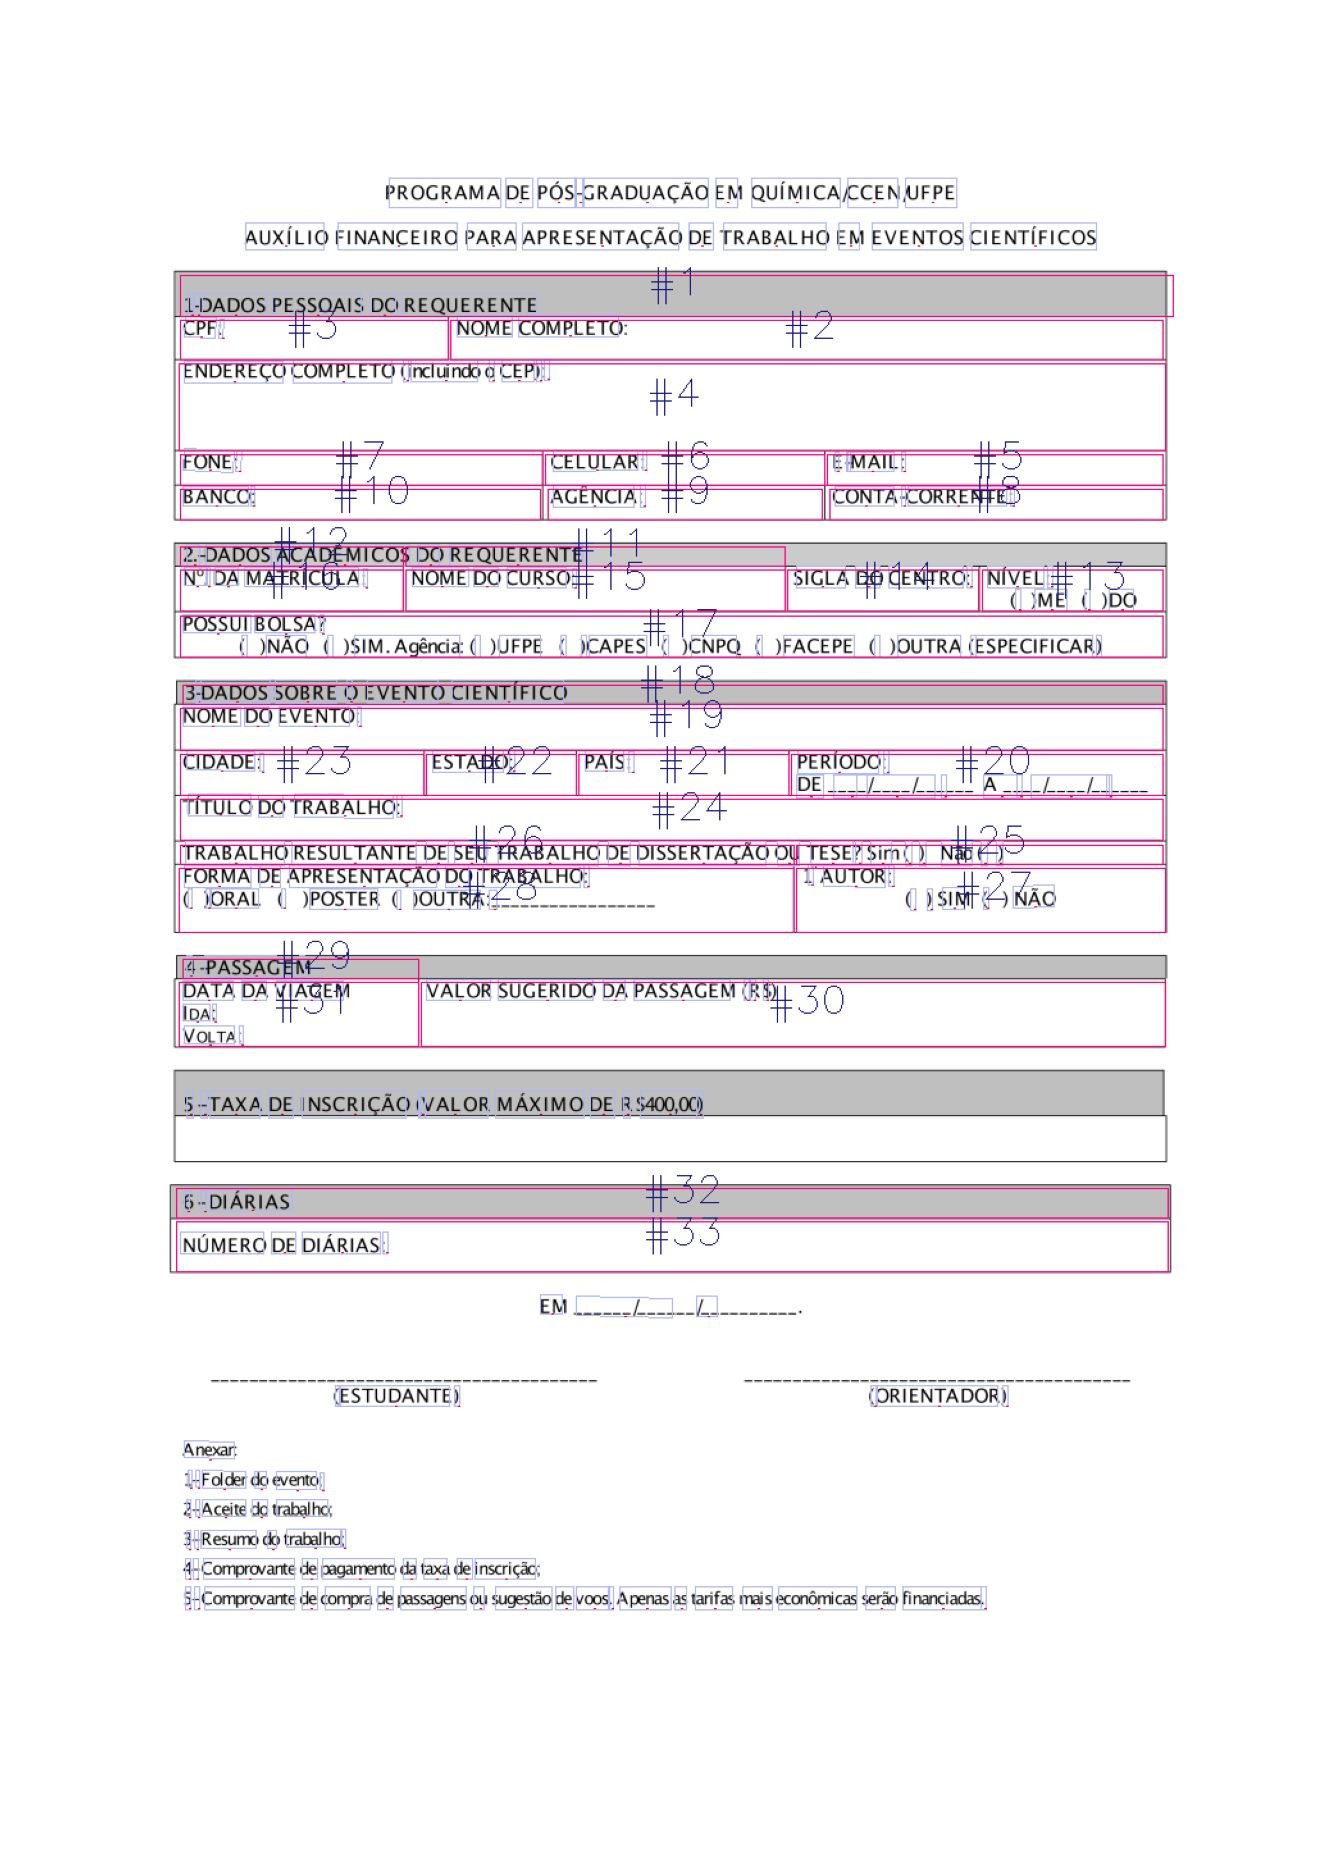

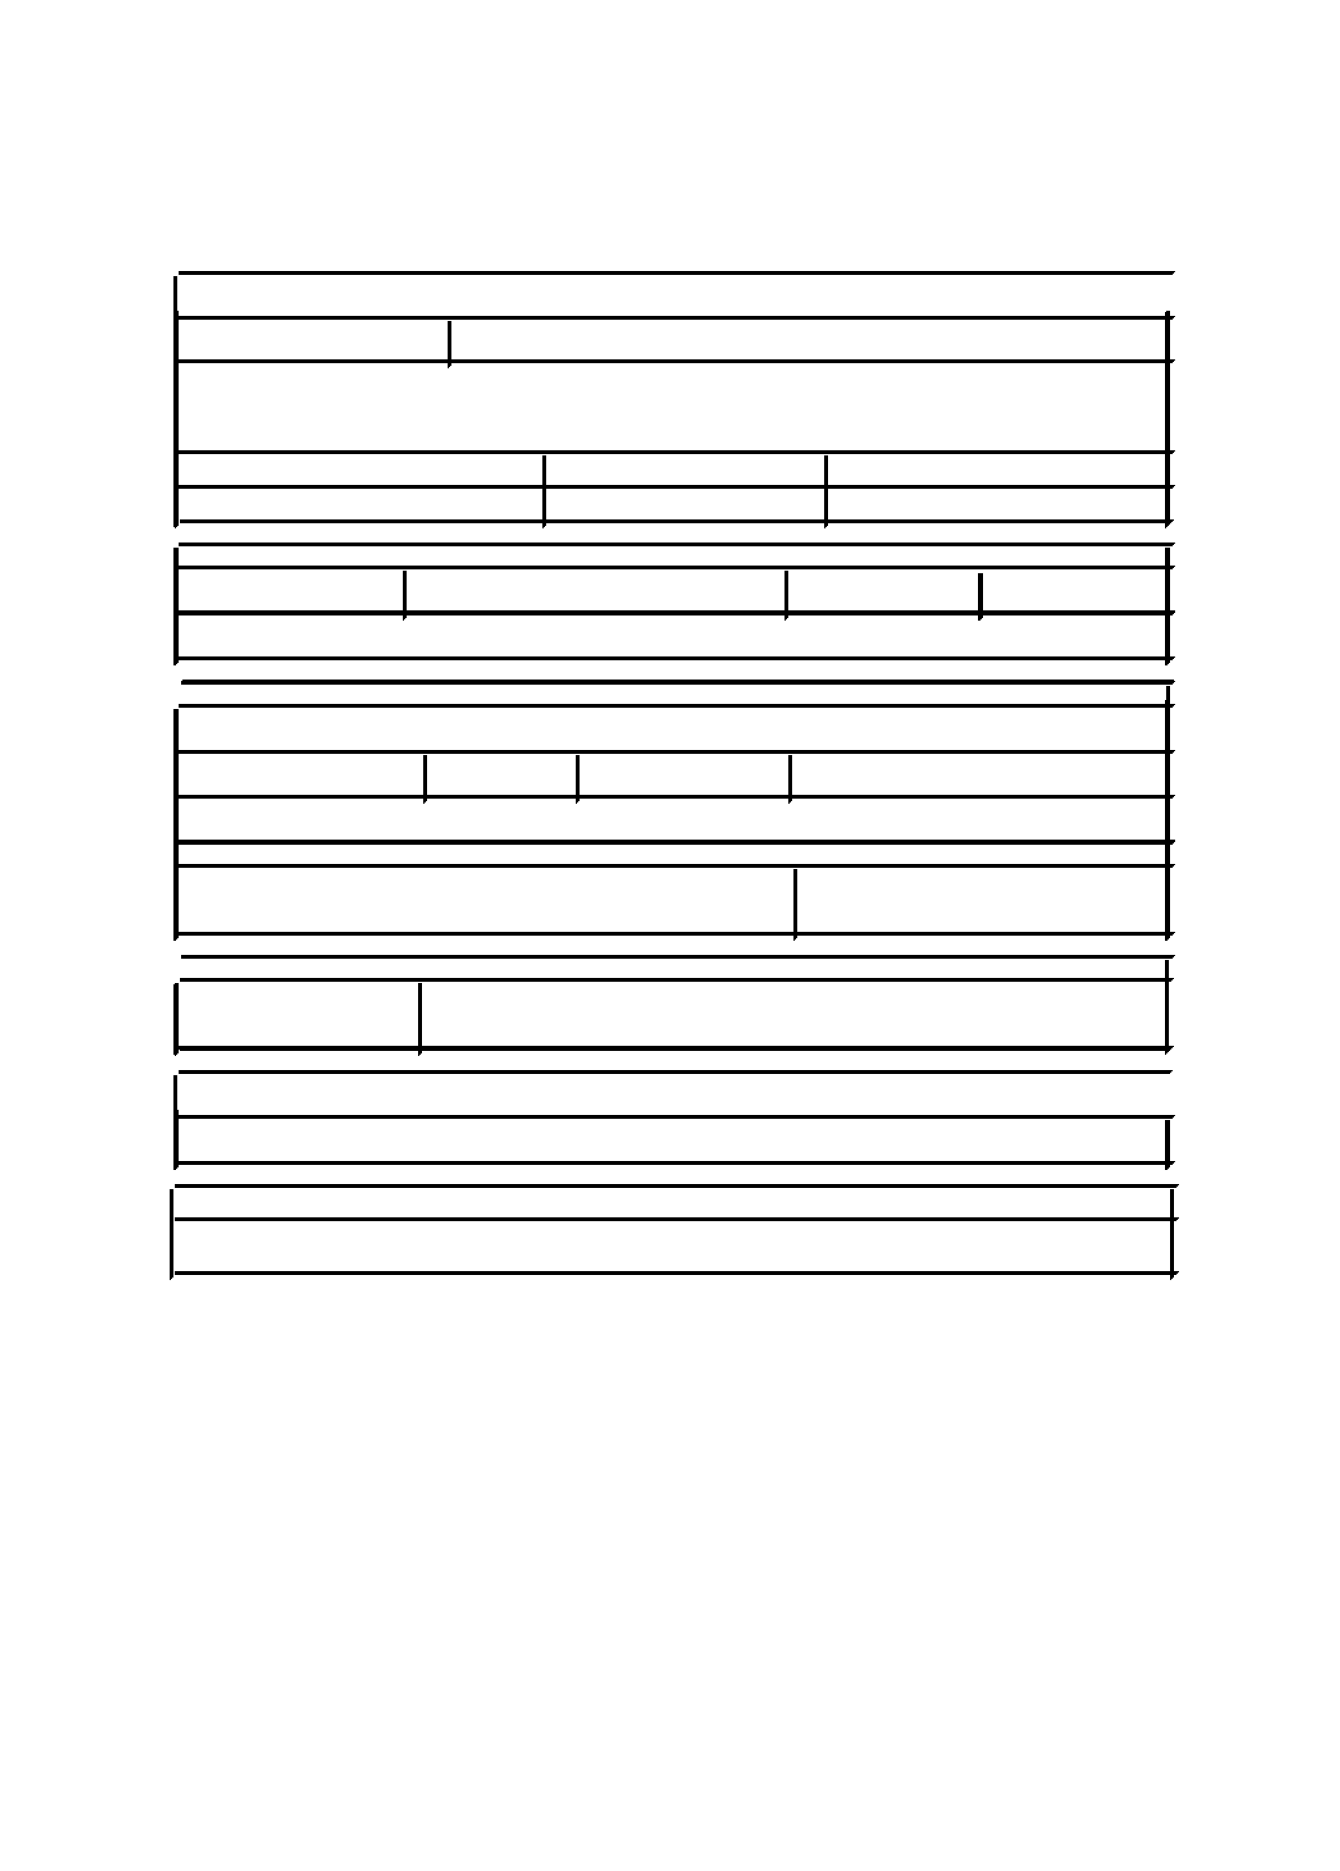

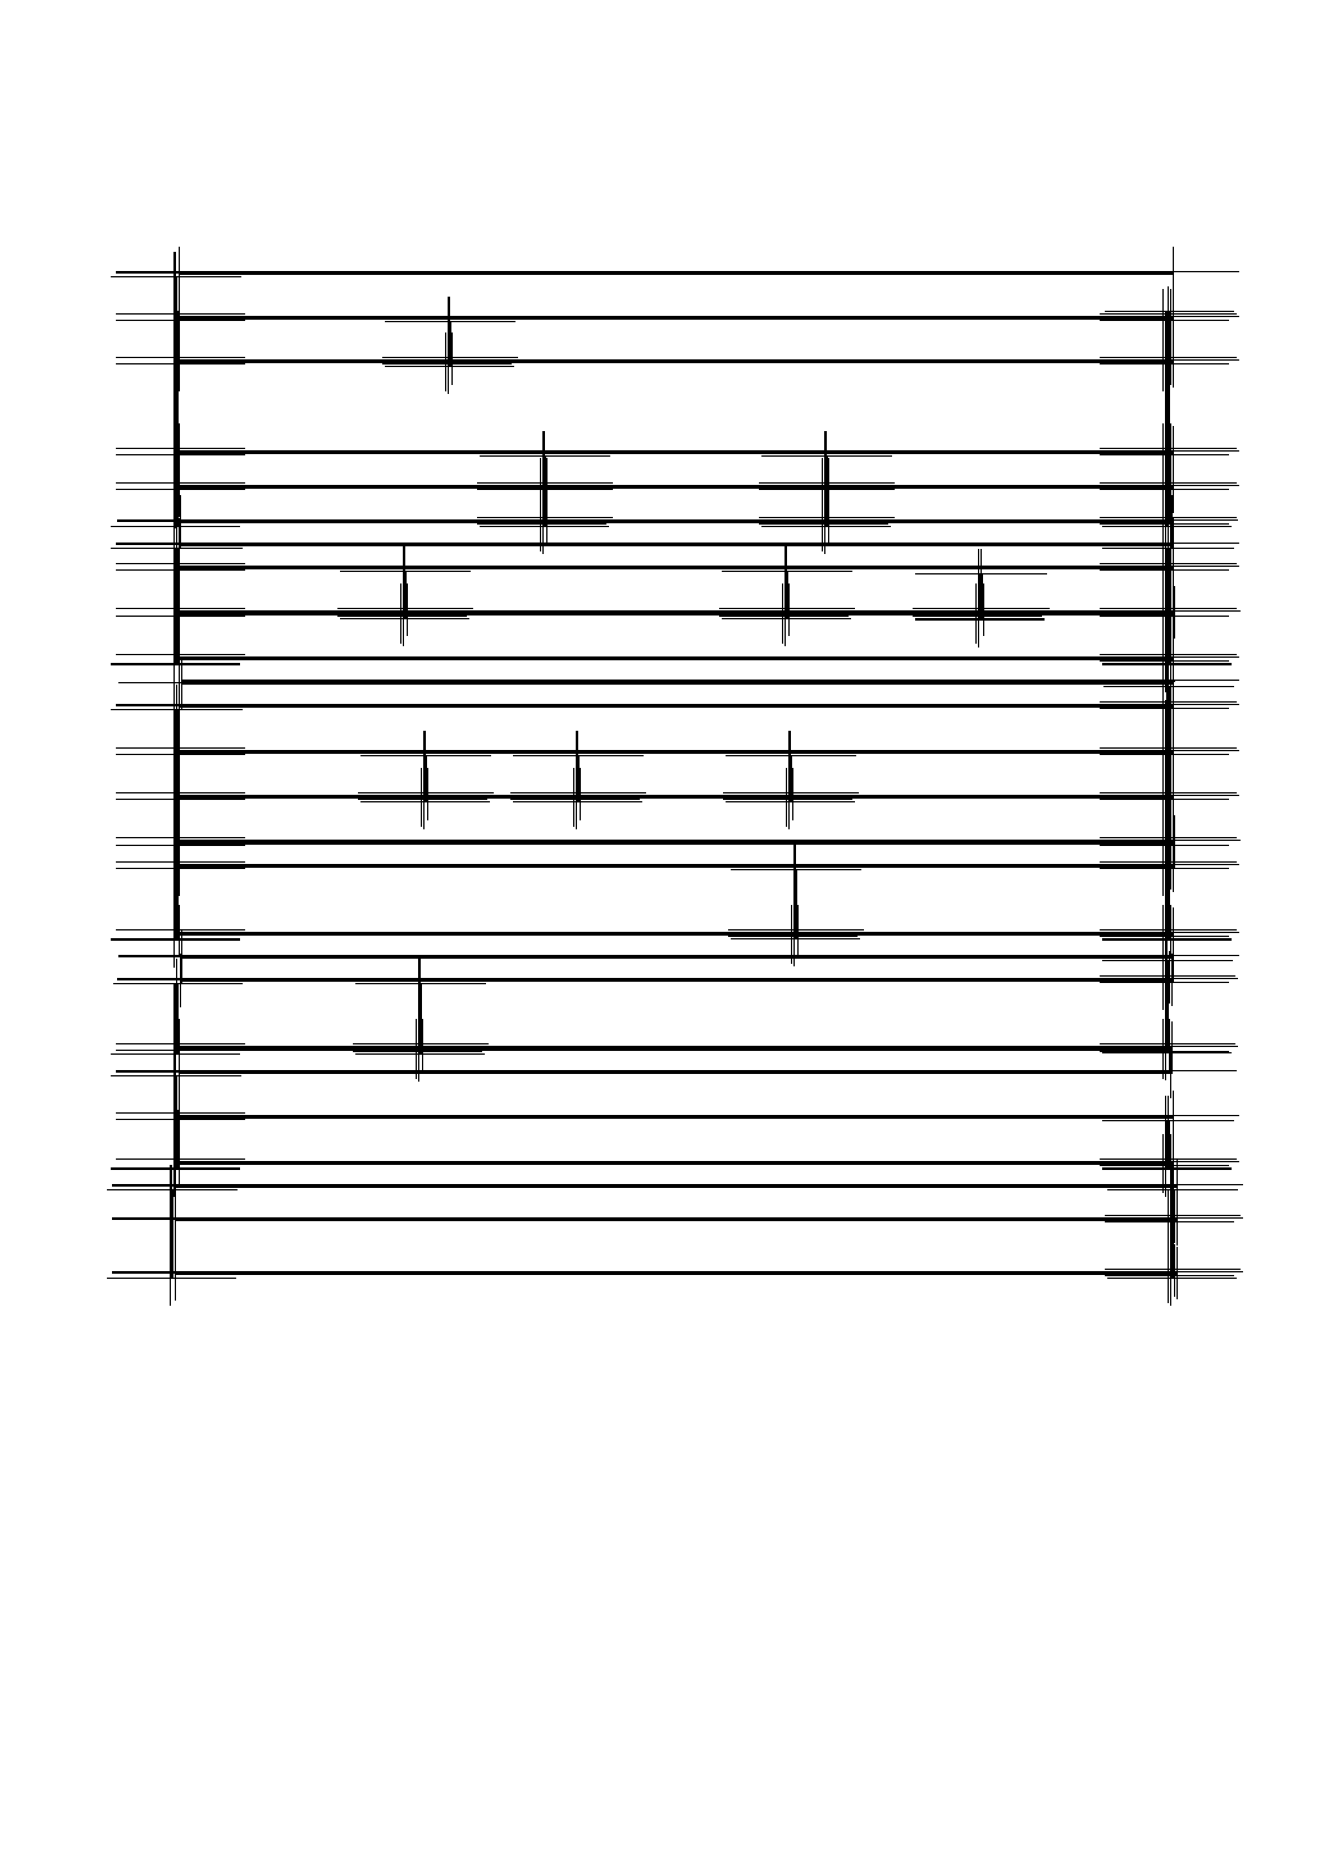

In [31]:
def complete_contours(image):
    """Completa os campos que são formados a partir do processamento de imag"""
    dst = cv2.cornerHarris(image,2,3,0.07)
    thresh = np.float16(0.4*dst.max())
    image= np.copy(image)
    for y in range(dst.shape[0]):
        for x in range(dst.shape[1]):
            if (dst[y,x] > thresh):
                cv2.rectangle(image, (x-1,y-20), (x-1,y+20), (0,0,255), 1)
                cv2.rectangle(image, (x-50,y-1), (x+50,y-1), (0,0,255), 1)
    return image

def sort_contours(contours):
    boundingBoxes = [cv2.boundingRect(c) for c in contours]
    (contours, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes),
                                            key=lambda b:b[1][1]))
    return contours, boundingBoxes

path = "/content/drive/My Drive/Colab Notebooks/Easydocs/documents/IIRGD/"
files= find_files(path)
arquivo = "/content/img.png"

inicio = time()
#######
image_ori = cv2.imread(arquivo)
image_gray = resize(cv2.imread(arquivo, 0))
image_ori = resize(image_ori)
denoised = noise_removal(image_gray)
image = preprocess_image(denoised)
#response = detect_document_text(image)
poligonos = find_polygons(response)
im = plot_polygons_image(image_ori,poligonos)
img_final1 = process_image(denoised)
img_final2 = complete_contours(img_final1)
contours = cv2.findContours(img_final2, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
contours,textos_caixa = filter_contours(contours,poligonos,im)
#########
fim = time()

print("Duração: ",round(fim - inicio,2),"segundos")
im = draw_boxes(contours,im)
plot_compare_images(im,img_final1,img_final2)

1 :  RG : 40.789.655-7
2 :  RESERVADO ( SÉRIE , NY , ESPELHO ) 6-418-076586-7
3 :  PAT : EDINET APARECIDO DA SILVA Ruth Roland
4 :  MAEMARCIA CRISTINA ALEXANDRE WINNER ZINOFCENDIR PASTAS AG ilala
5 :  NATURALIDADE RANCHARIA / SP RG29.723.267
6 :  DATA DE NASCIMENTO 12/08/1994
7 :  SEXO
8 :  PIS . PASEP
9 :  CPF :
10 :  DOCUMENTOS APRESENTADOS CERTIDÃO CERTIDÃO NASCIMENTO Casalento
11 :  CARTÓRIO RANCHARTA / SP
12 :  COMARCA RANCHARIA / SP
13 :  DATA 24/10/2006
14 :  NÚMERO 013621
15 :  FOLHA 390
16 :  LIVRO A - 54
17 :  IDENTIFICAÇÃO 12-07-2007
18 :  PORT . MINIST . Nº
19 :  NAC . PORTUGUESA DECRETO 70.391 / 72 PORT . MINIST . NO
20 :  GRAU DE INSTRUÇÃO 1 GRAU
21 :  ALTURA 1.61
22 :  OLHOS CASTANHOS
23 :  CABELOS CASTANHOS
24 :  CUTIS BRANCA
25 :  ESTADO CIVIL SOLTEIRA
26 :  ENDEREÇO DA RESIDENCIA RUA CORONET . GALDINO . 712 27422-5
27 :  PROFISSÃO ESTUDANTE
28 :  ASSINATURA
29 :  AS INFORMAÇOES CONTIDAS NESTA FICHA SÃO DE RESPONSABILIDADE DO IDENTIFICADO ( DECLARO NÃO SEA DOADOR DE OR

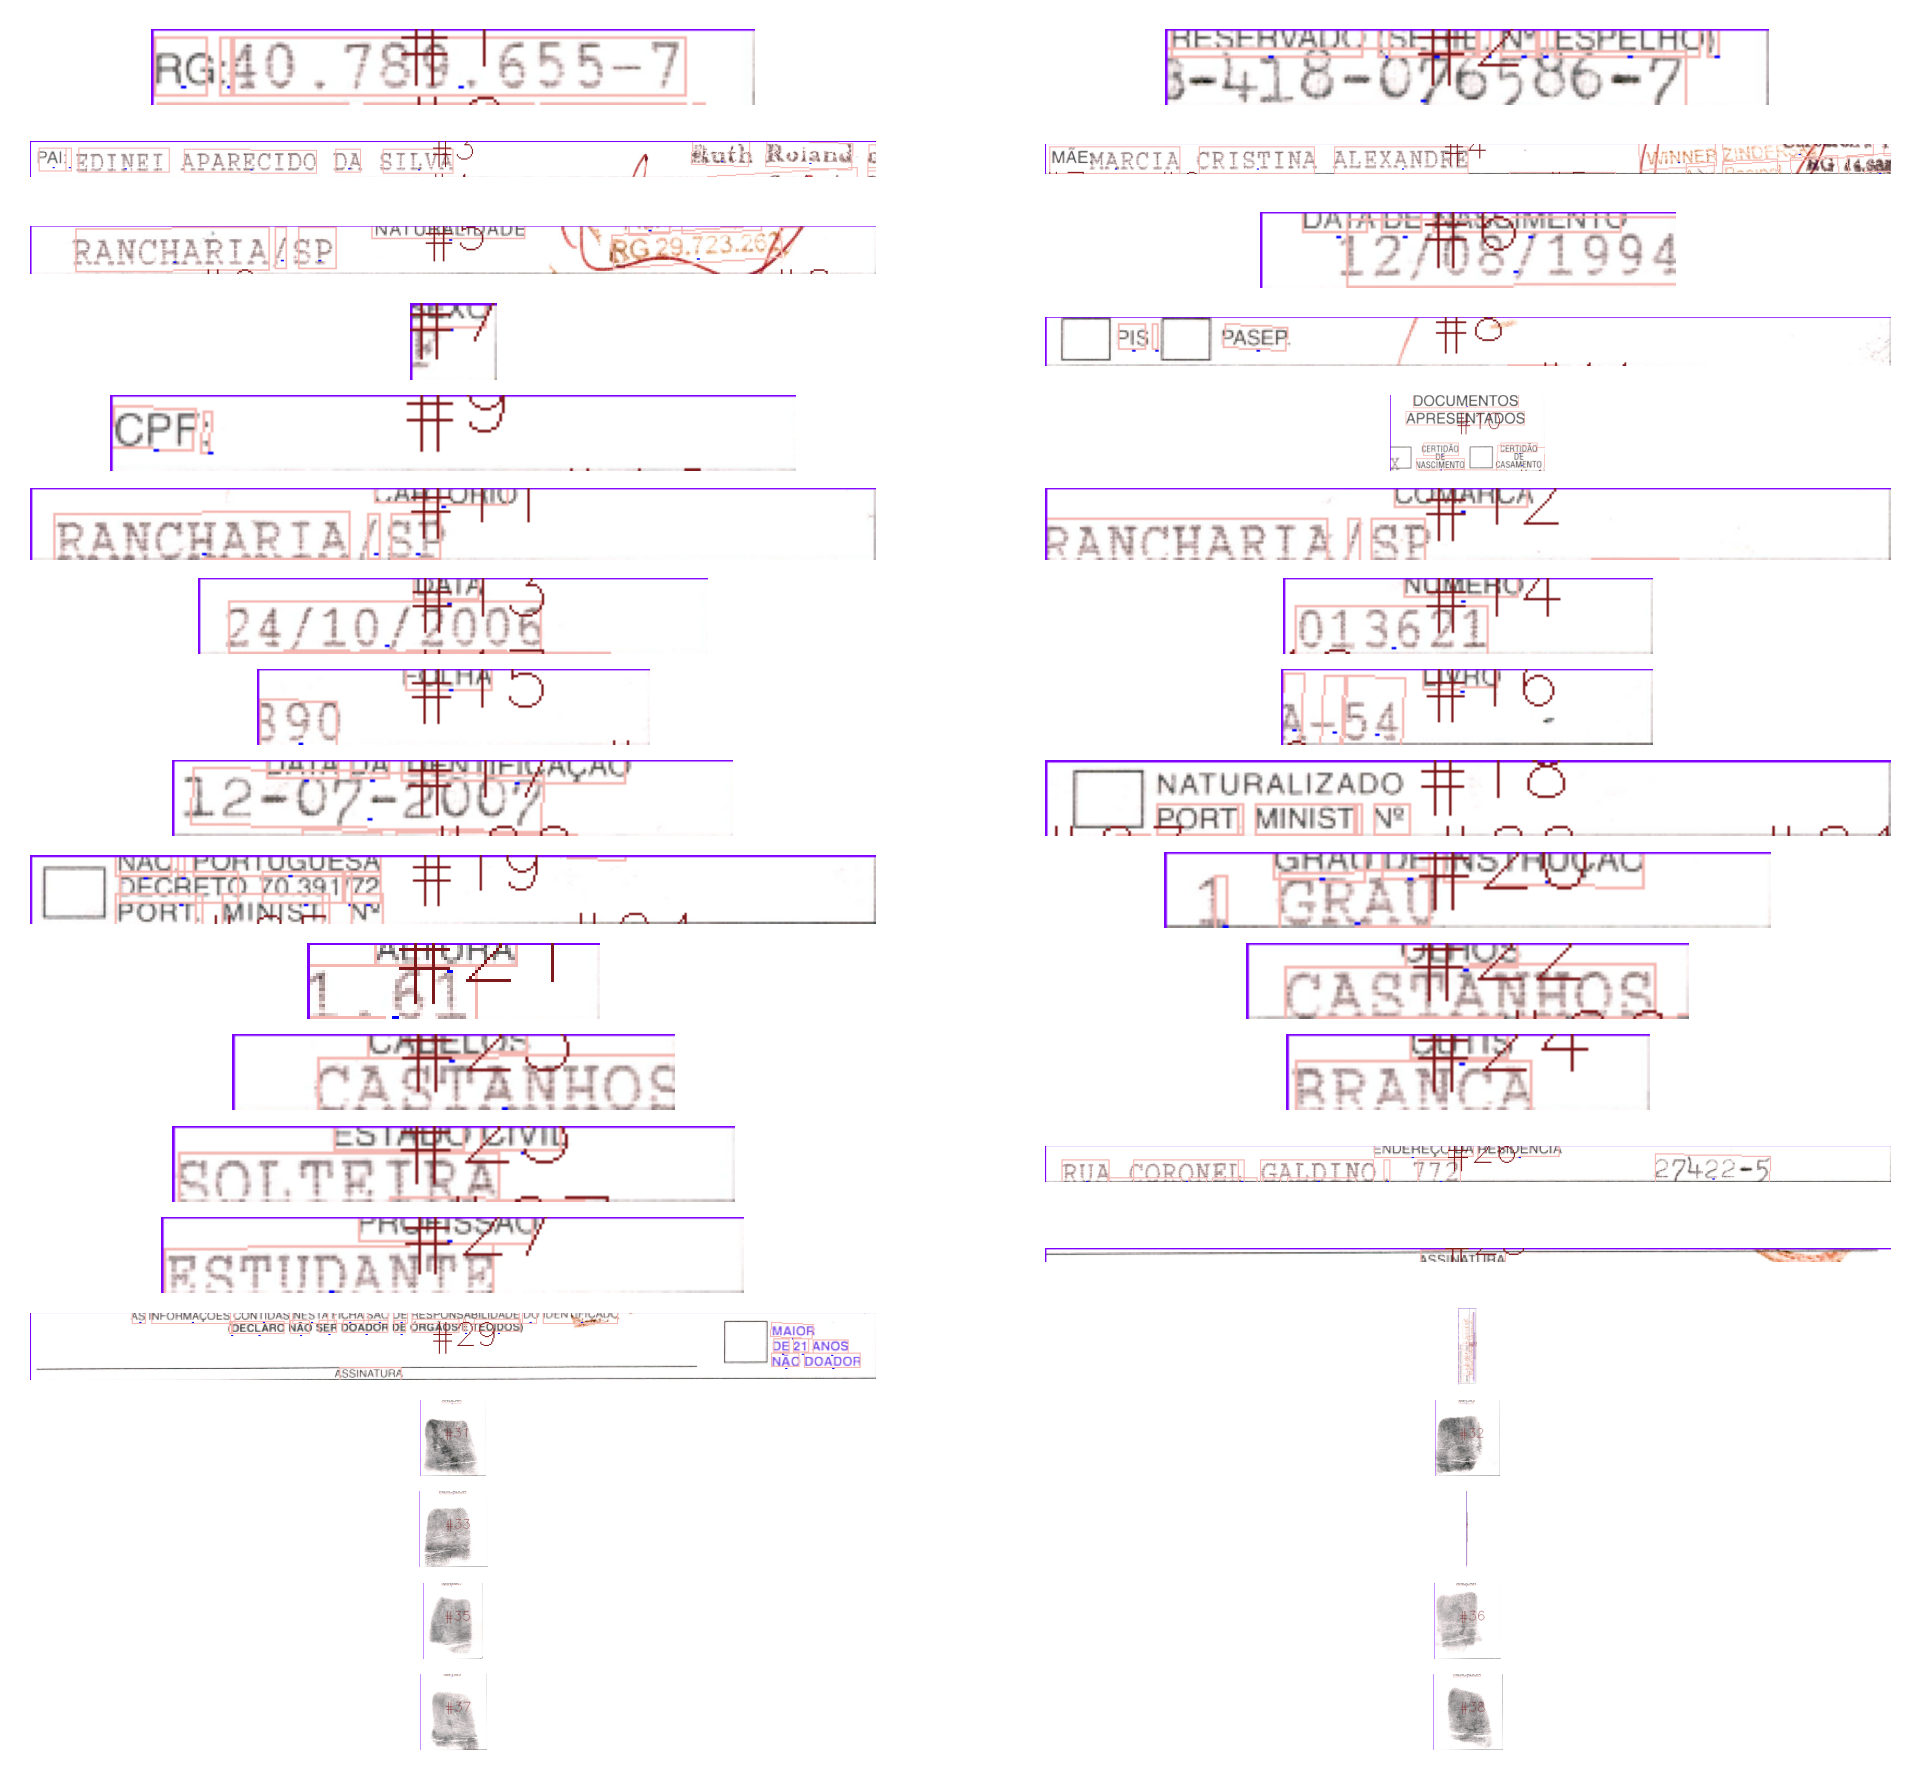

In [ ]:
[print(i+1,": ",texto[0]) for i,texto in enumerate(textos_caixa)]
plot_boxes(im,contours)

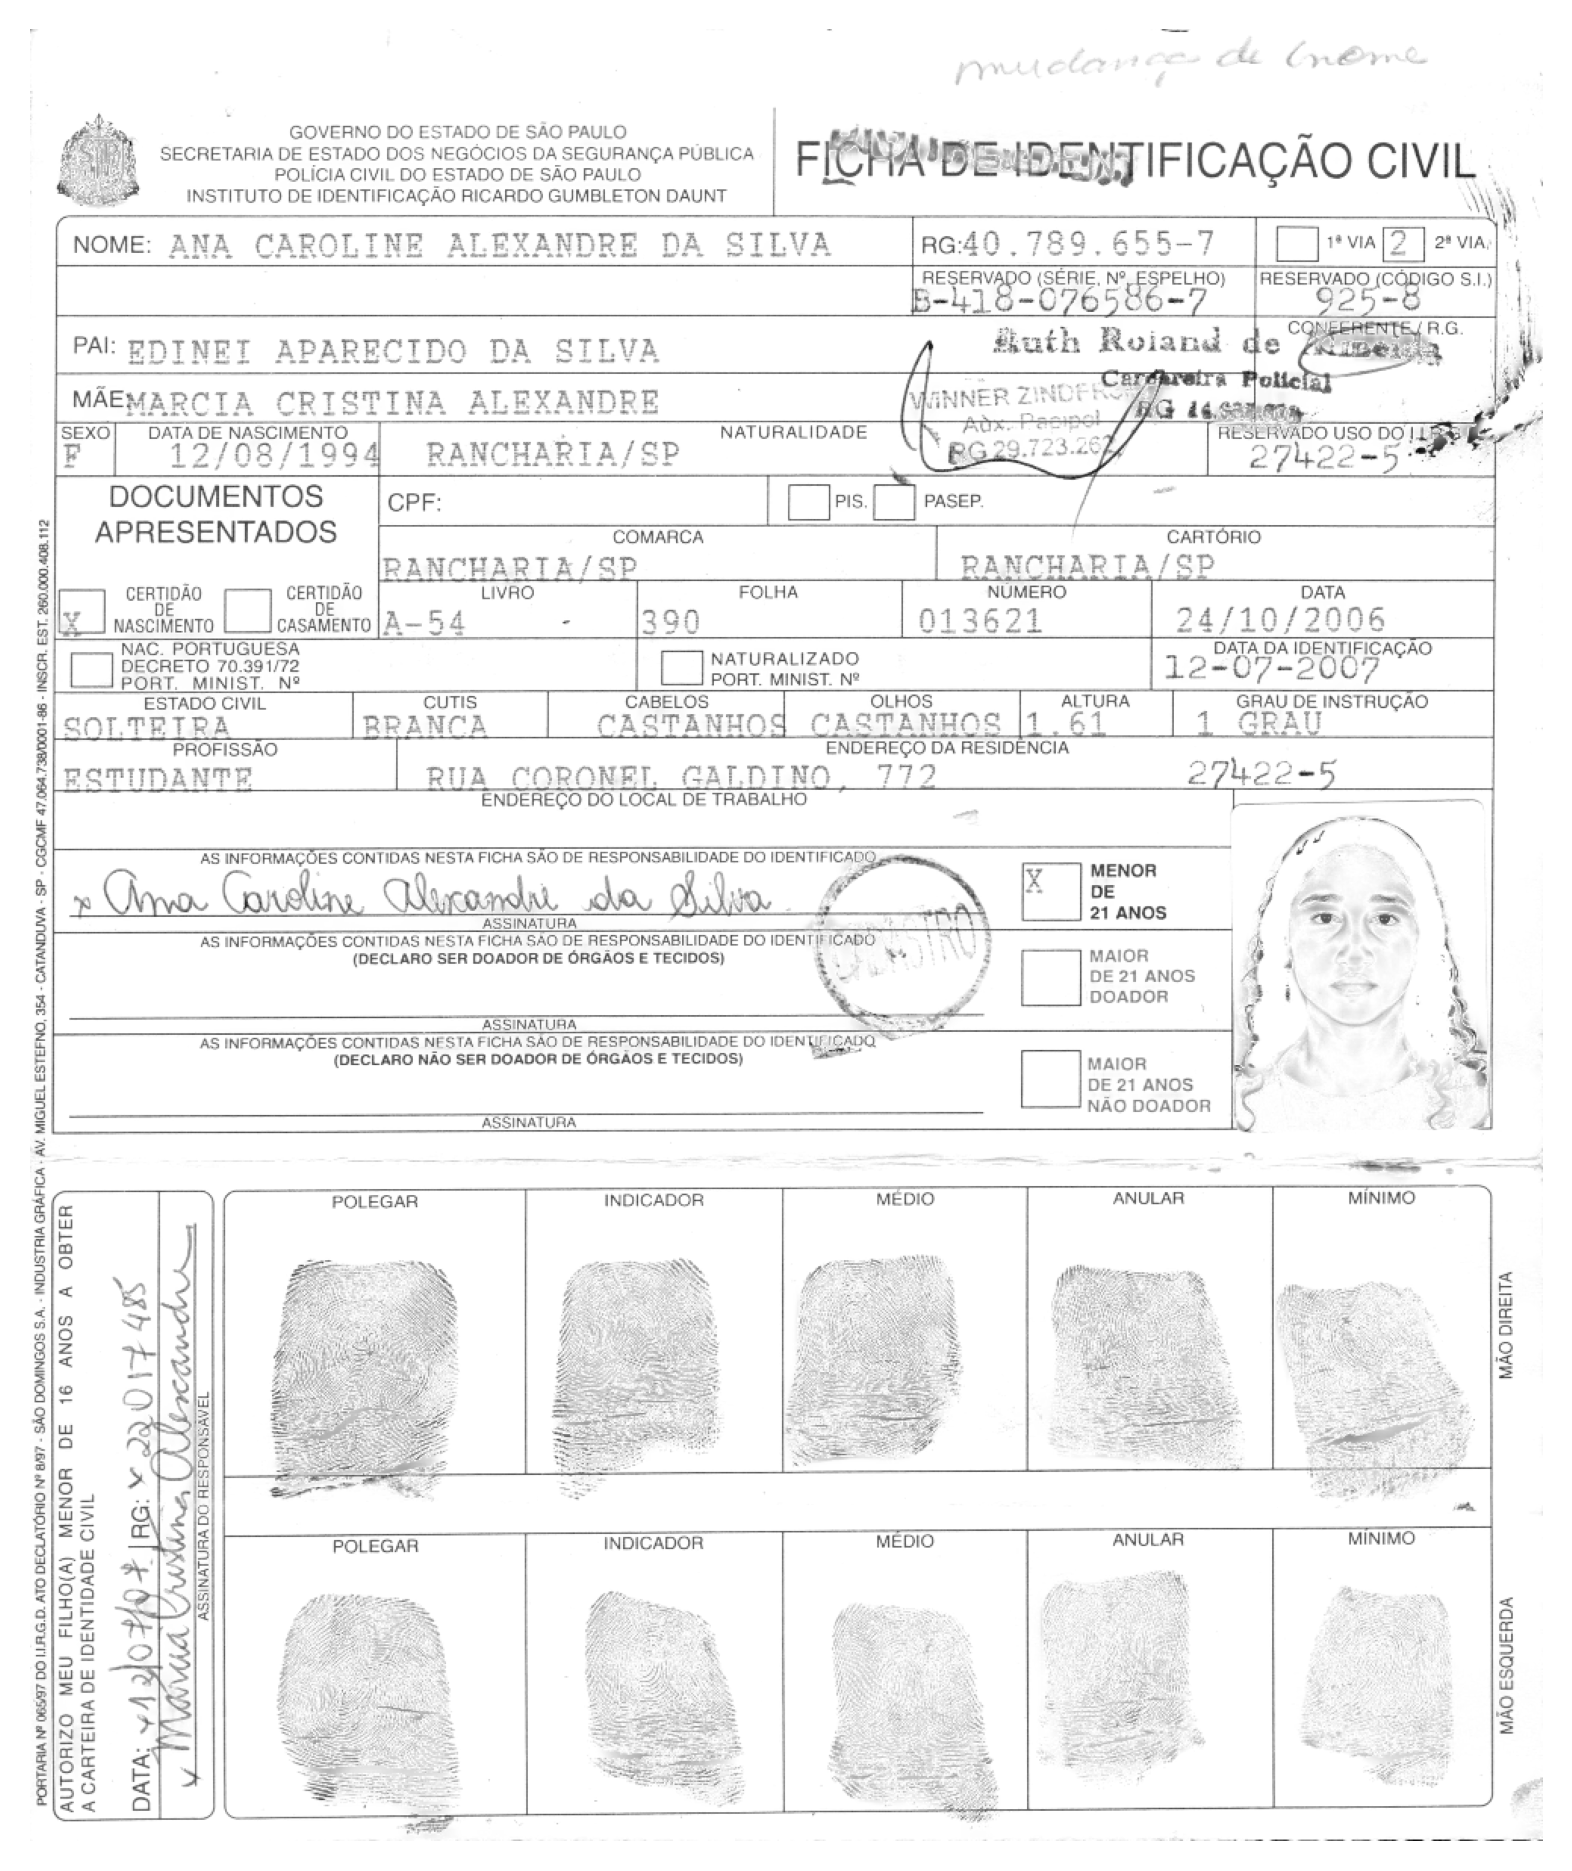

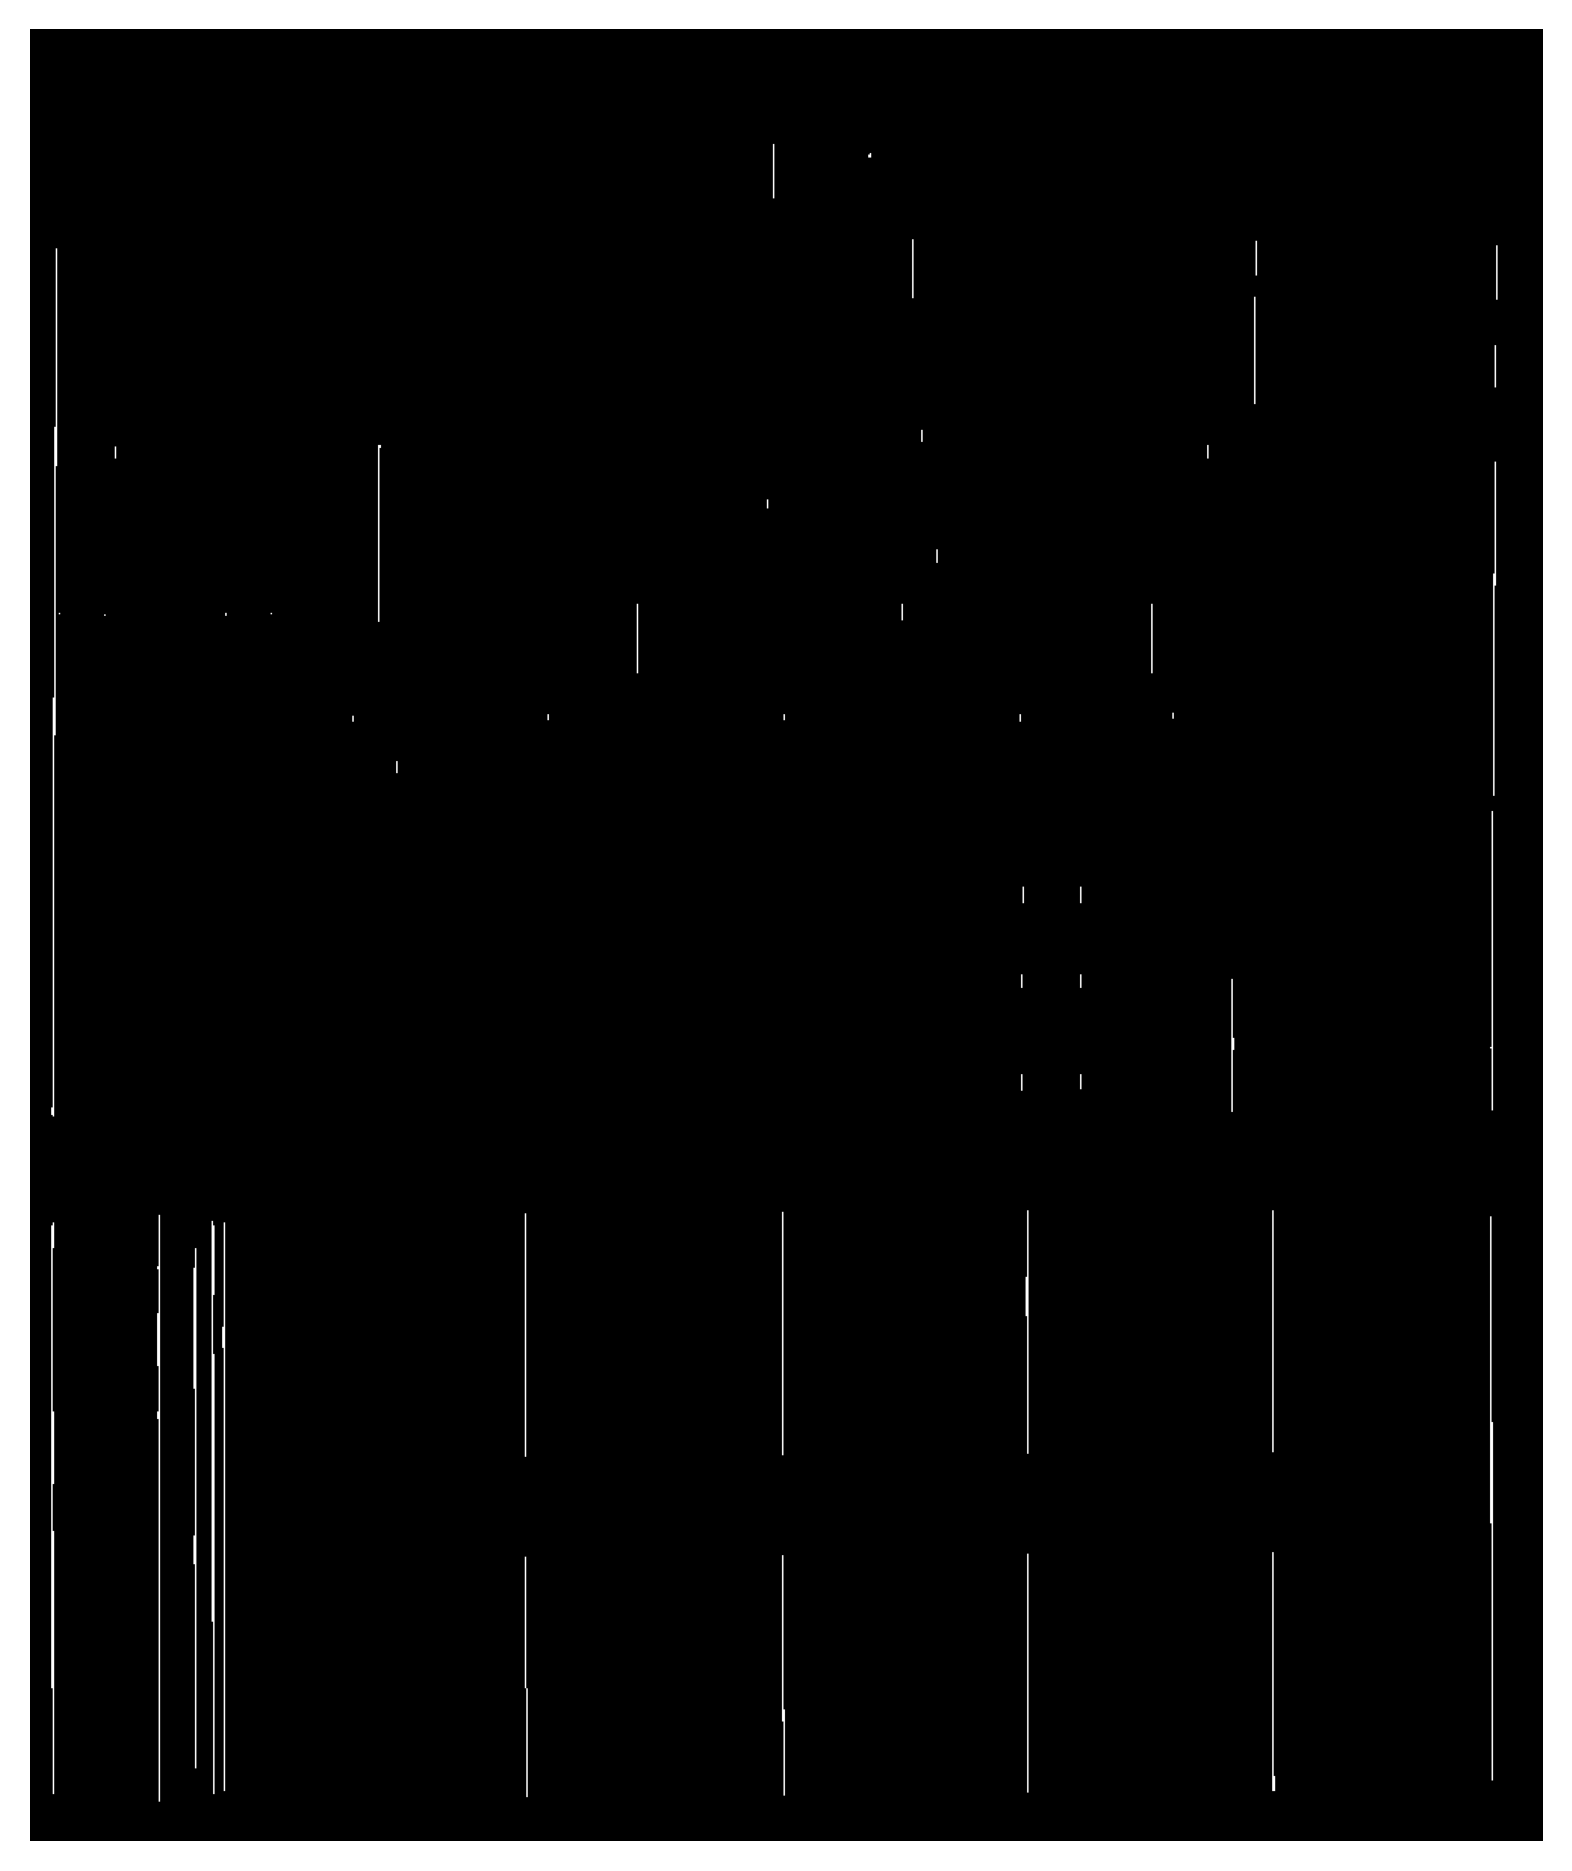

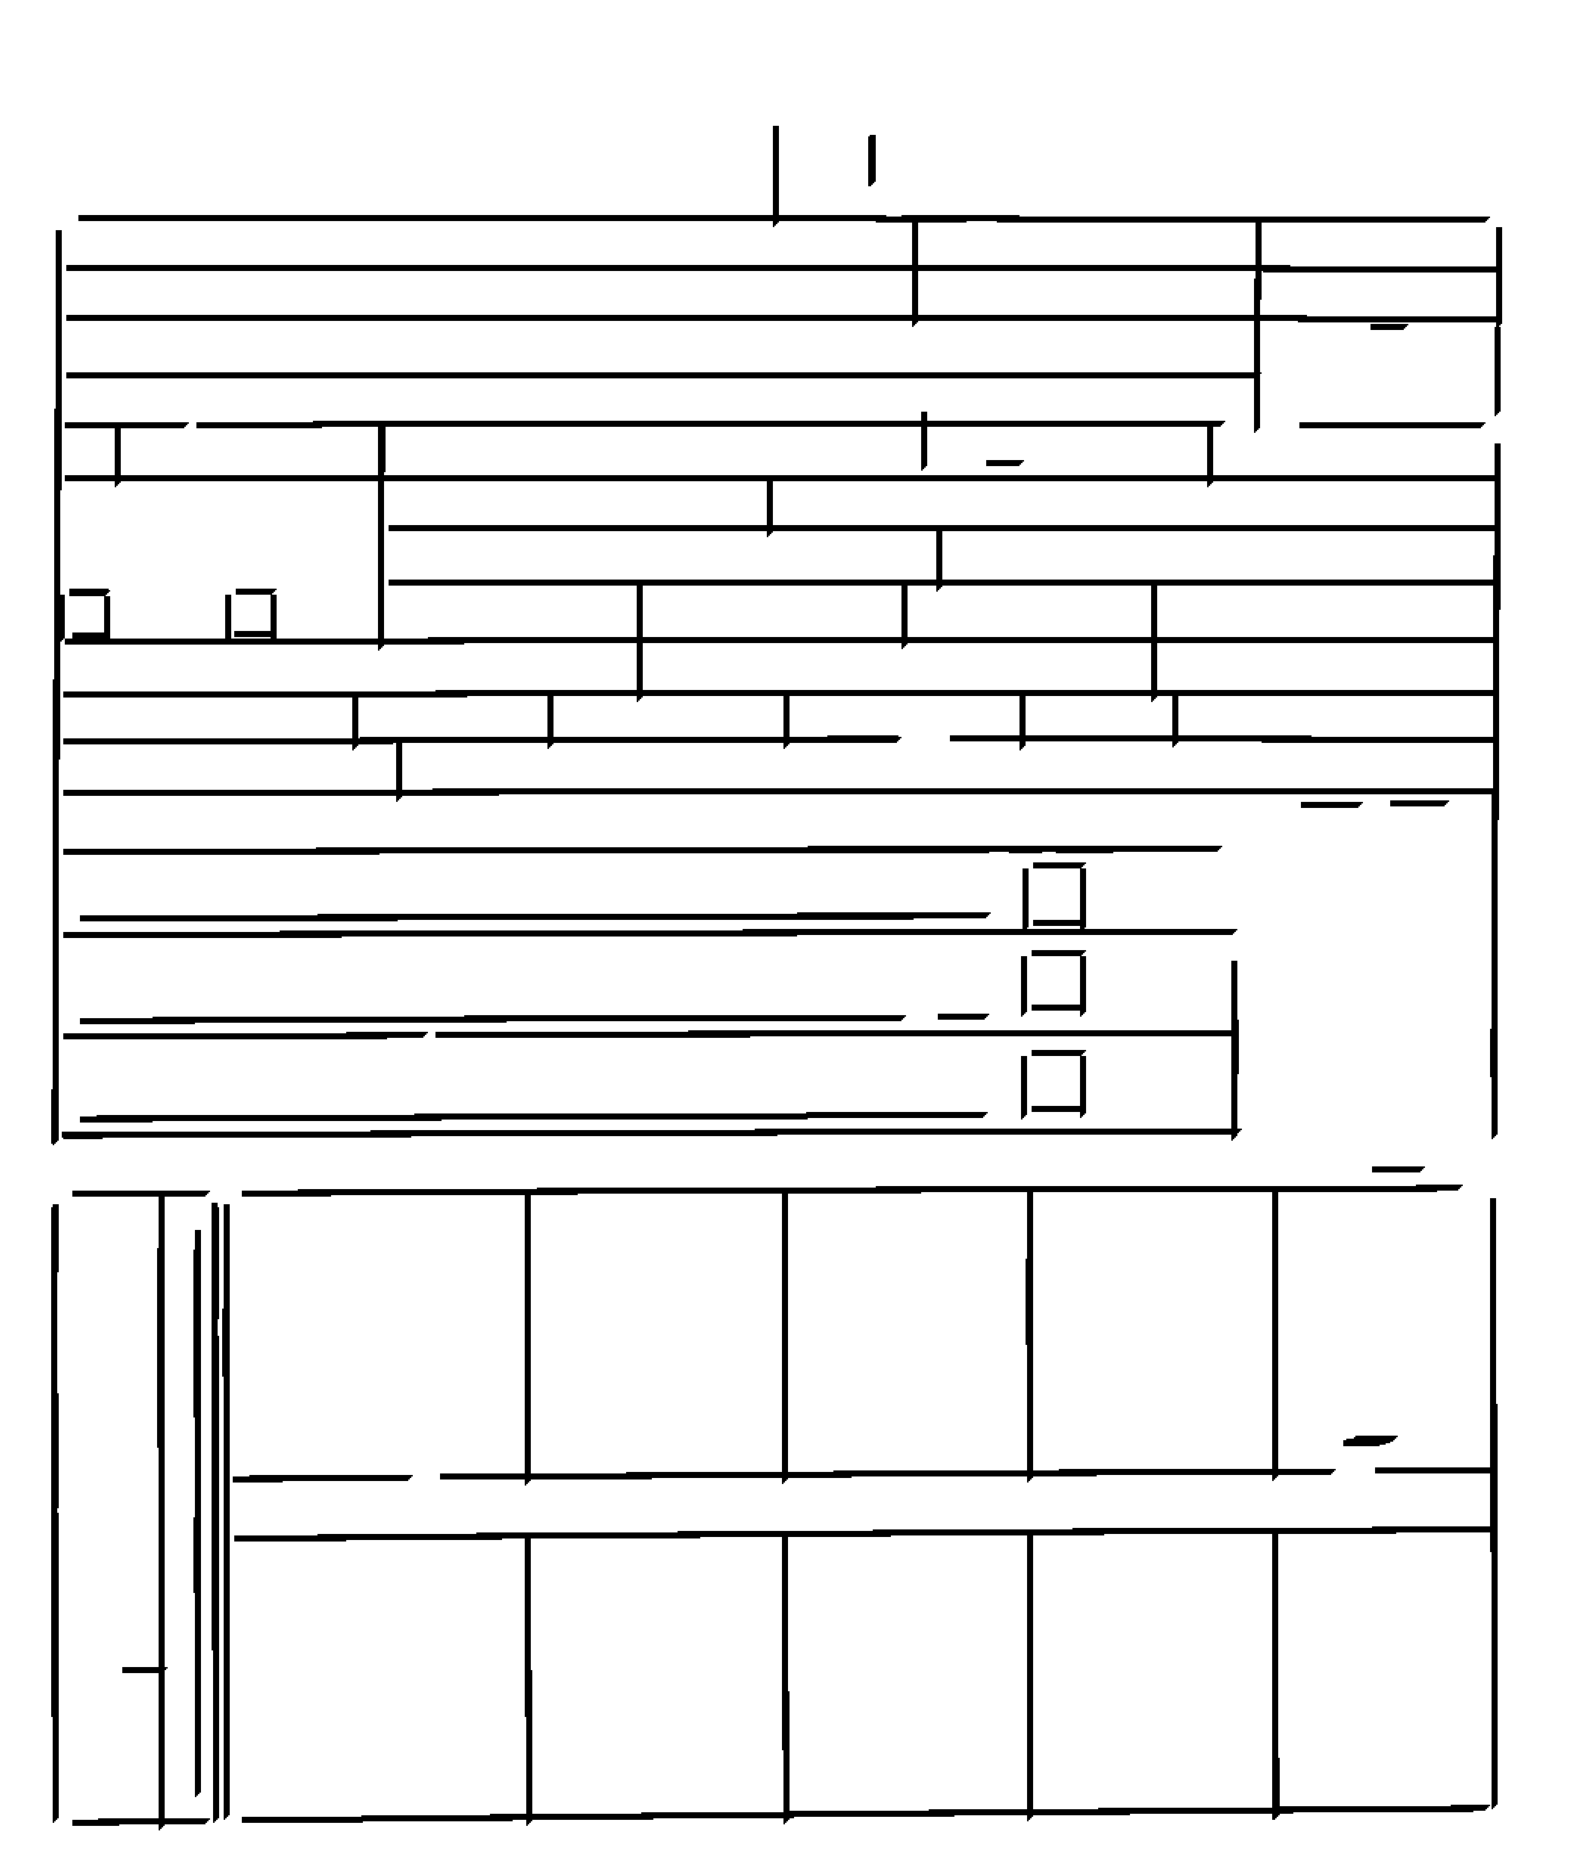

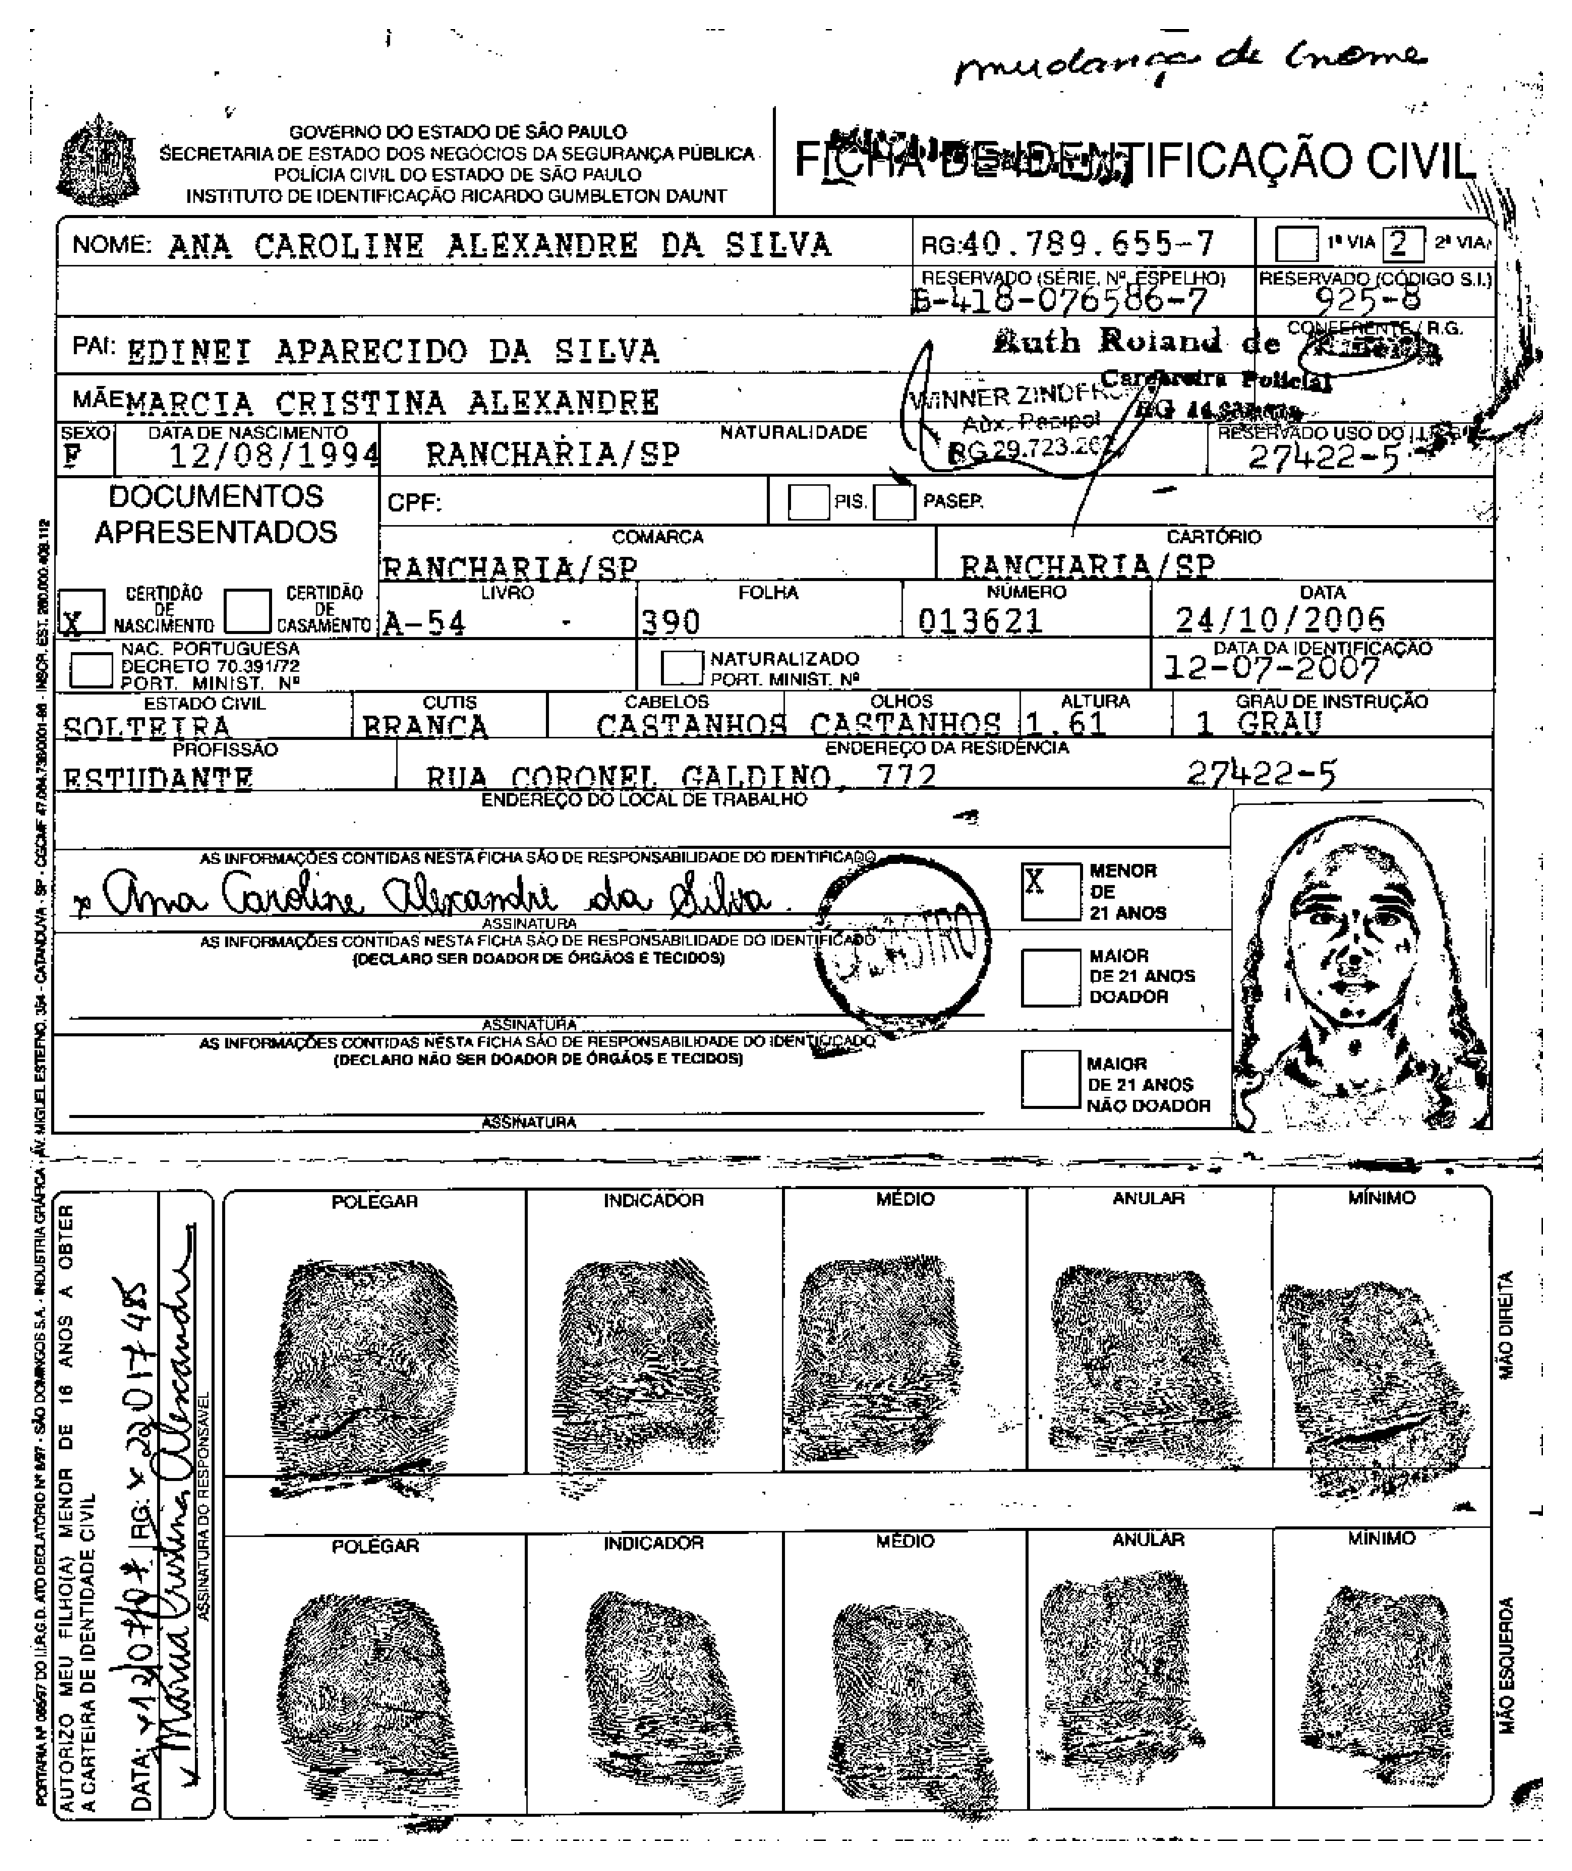

In [ ]:
def noise_removal(image):
    """Remove ruídos, tranforma a imagem em escala de cinza e devolve apenas a estrutura encontrada"""
    try:
        rgb_planes = cv2.split(image)
        result_norm_planes = []
        for plane in rgb_planes:
            dilated_img = cv2.dilate(plane, np.ones((1,1), np.uint8))
            bg_img = cv2.medianBlur(dilated_img, 21)
            diff_img = 255 - cv2.absdiff(plane, bg_img)
            norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
            result_norm_planes.append(norm_img)
        image = cv2.merge(result_norm_planes)
    except Exception as e:
        print(e)
        return f"Error: {e}"
    return image

image_gray = resize(cv2.imread(arquivo, 0))
denoised = noise_removal(image_gray)
img = denoised
alpha = 0.5
beta = 1.0 - alpha
thresh = cv2.threshold(img, 180, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)[1]
bitwise = cv2.bitwise_not(thresh)
erosion = cv2.erode(bitwise, ones((1, 1) ,uint8), iterations=4)
img_bin = cv2.dilate(erosion, ones((1, 1) ,uint8), iterations=4)
kernel_length = array(img_bin).shape[1]//120
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (1, kernel_length))
hori_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (kernel_length, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (2, 2))
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=4)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=4)
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=4)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin_erode = cv2.erode(~img_final_bin, kernel, iterations=3)
img_final_bin = cv2.threshold(img_final_bin_erode, 180,255, cv2.THRESH_BINARY | cv2.THRESH_BINARY)[1]

thresh_text_img = cv2.adaptiveThreshold(img,
                                        maxValue=255,
                                        adaptiveMethod=cv2.THRESH_BINARY_INV,
                                        thresholdType=cv2.THRESH_BINARY,
                                        blockSize=77,
                                        C=3)

fases = [img,img_temp1,img_final_bin,thresh_text_img ]
plot_compare_images(*fases)

In [ ]:
alpha = 0.5
beta = 1.0 - alpha
img = cv2.imread(arquivo, 0)
rgb_planes = cv2.split(img)
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_norm_planes.append(norm_img)
img = cv2.merge(result_norm_planes)
_, thresh = cv2.threshold(img, 180, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
bitwise = cv2.bitwise_not(thresh)
erosion = cv2.erode(bitwise, ones((1, 1) ,uint8), iterations=4)
img_bin = cv2.dilate(erosion, ones((1, 1) ,uint8), iterations=4)
kernel_length = array(img_bin).shape[1]//100
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (1, kernel_length))
hori_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (kernel_length, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3, 3))
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=4)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=4)
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=4)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin_erode = cv2.erode(~img_final_bin, kernel, iterations=4)
_, img_final_bin = cv2.threshold(img_final_bin_erode, 180,255, cv2.THRESH_BINARY | cv2.THRESH_BINARY)

#fases = [img,thresh,bitwise,erosion,img_bin,img_temp1,img_temp2,horizontal_lines_img,img_final_bin_erode,img_final_bin,thresh_text_img ]
thresh_text_img = cv2.adaptiveThreshold(img,
                                        maxValue=255,
                                        adaptiveMethod=cv2.THRESH_BINARY_INV,
                                        thresholdType=cv2.THRESH_BINARY,
                                        blockSize=99,
                                        C=3)

fases = [img,img_final_bin,img_final,thresh_text_img ]
plot_compare_images(*fases)

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Easydocs/documents/IIRGD/"
files= find_files(path)
arquivo = files[8]

inicio = time()
denoised = noise_removal(arquivo)
image = preprocess_image(denoised)
response = detect_document_text(image)
poligonos = find_polygons(response)
im = plot_polygons_image(arquivo,poligonos)
img_final = process_image(denoised)
img_final = complete_contours(img_final)
contours,hierarchy = cv2.findContours(img_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours,textos_caixa = filter_contours(contours,poligonos,im)
fim = time()

print("Duração: ",round(fim - inicio,2),"segundos")
im = draw_boxes(contours,im)
plot_compare_images(im)
    

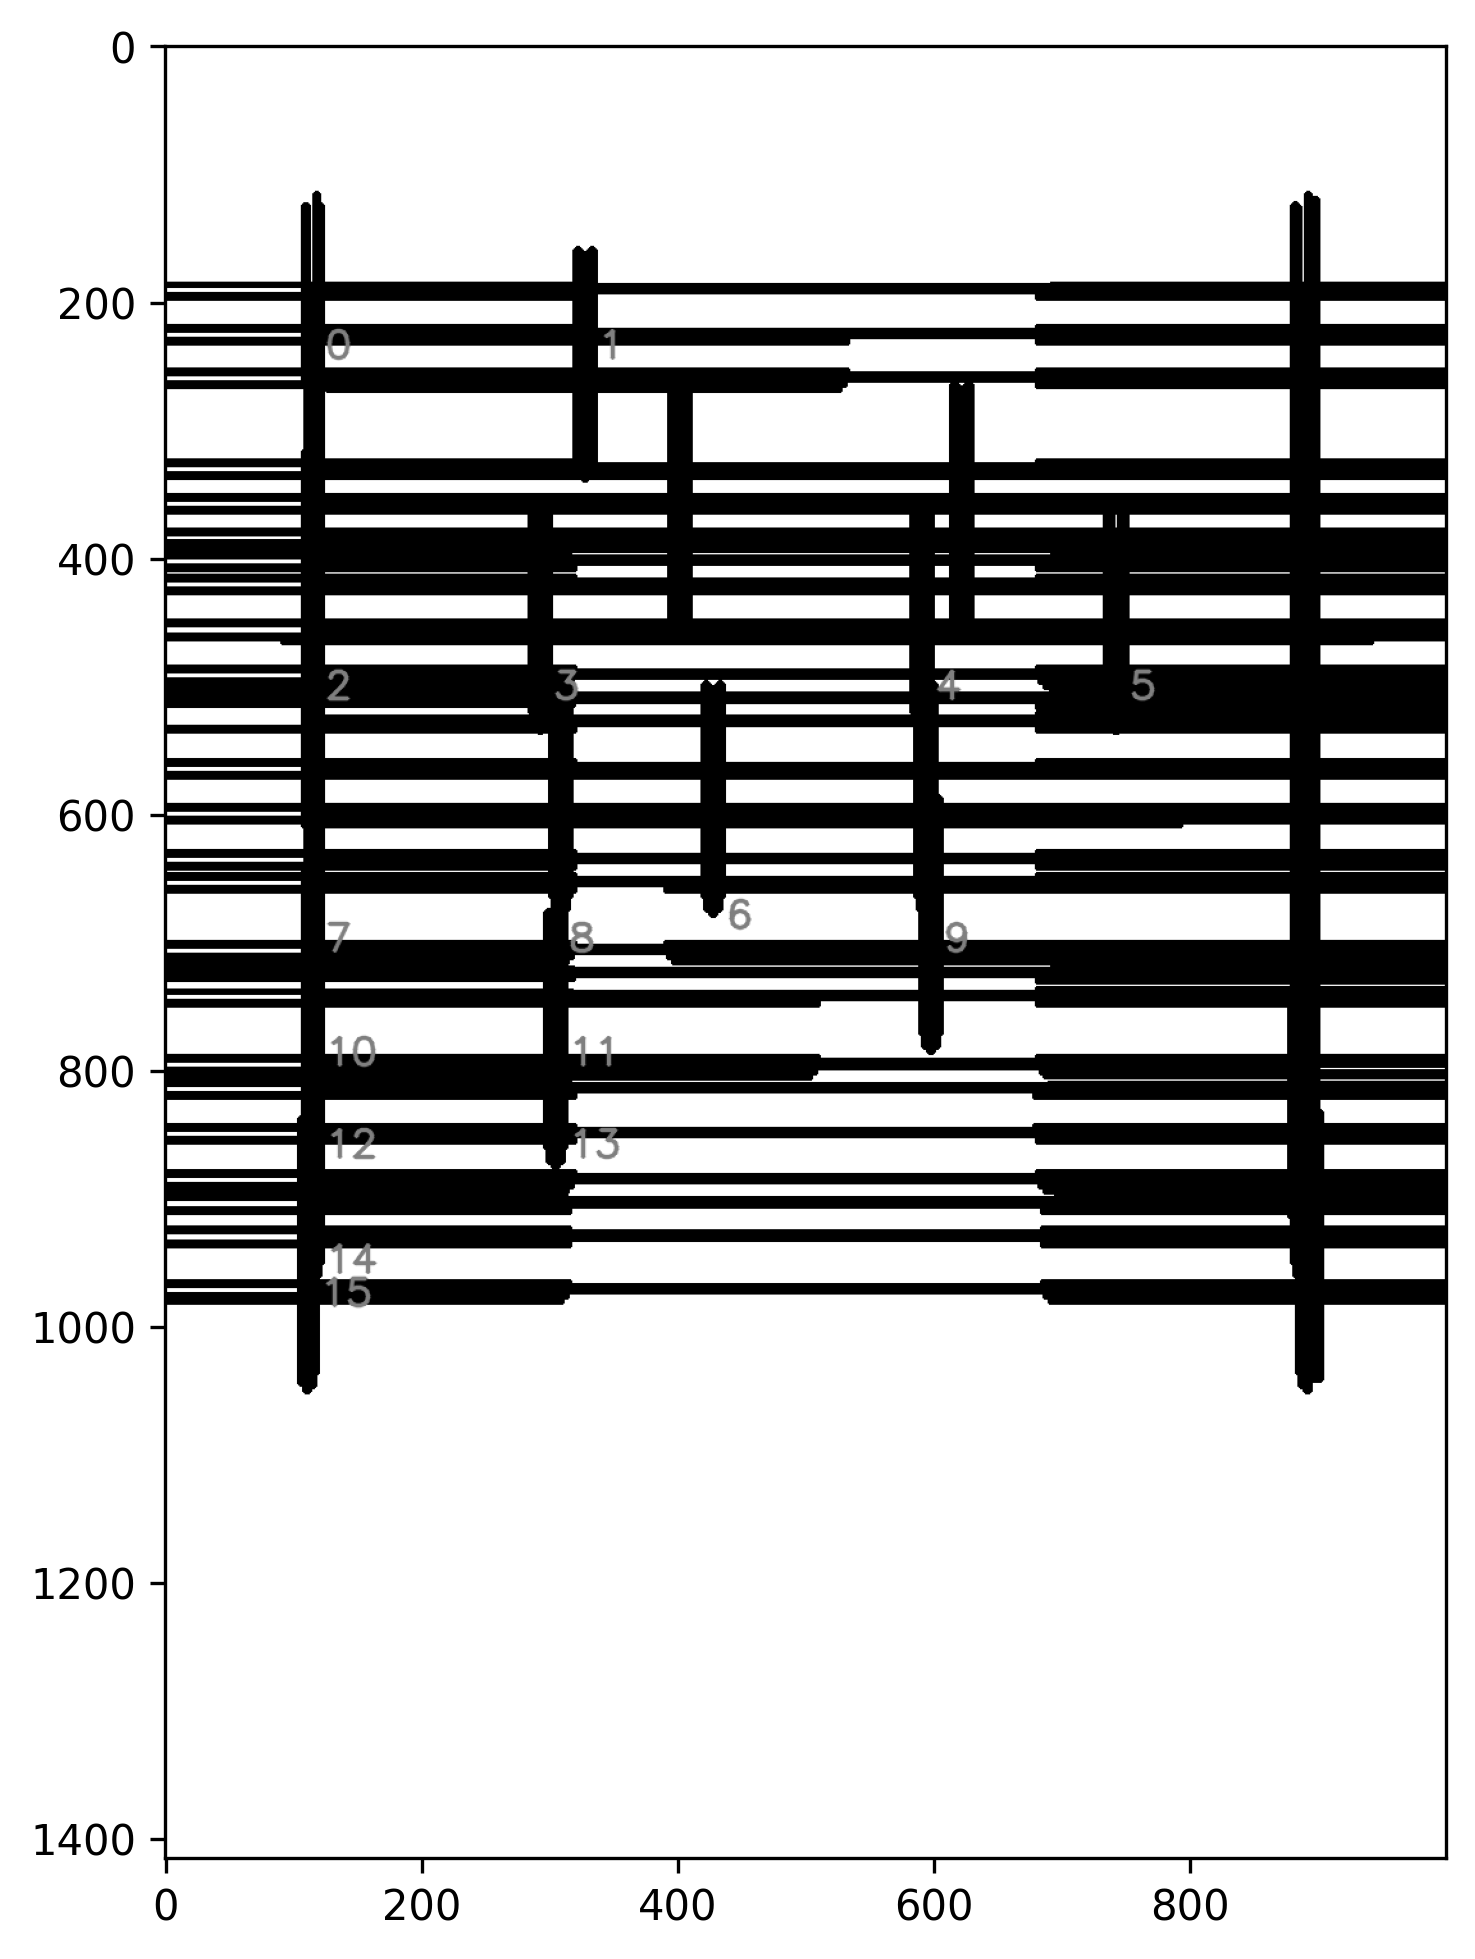

In [ ]:
h,w = img_final.shape[:2]
sumOfRows = np.sum(img_final, axis=1)
startindex = 0
lines = []
compVal = True
for i, val in enumerate(sumOfRows):
    testVal = (val > 0)
    if testVal == compVal:
            if val == 0:
                lines.append((startindex,i))
                startindex = i+1
            compVal = not compVal

contours = cv2.findContours(img_final, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0]
contours,_ = filter_contours(contours,poligonos,im)
lineContours = []
for j,cnt in enumerate(contours):
    (x,y,w,h) = cv2.boundingRect(cnt)
    for i,line in enumerate(lines):
        if y >= line[0] and y <= line[1]:
            lineContours.append([line[0],x,j])
            break
contours_sorted = sorted(lineContours)
for i, cnt in enumerate(contours_sorted):
    line, xpos, cnt_index = cnt
    cv2.putText(img_final,str(i),(xpos,line+50),cv2.FONT_HERSHEY_SIMPLEX,1,(127),2,cv2.LINE_AA)
plt.imshow(img_final)

In [ ]:
import requests
url = 'https://www.ufpe.br/documents/40058/219935/Formul%C3%A1rio+para+pedido+de+aux%C3%ADlio+financeiro+para+participa%C3%A7%C3%A3o+em+eventos+cient%C3%ADficos+-+Discente.pdf/04d42739-8c7d-4eed-95d2-65941778c473?version=1.0&previewFileIndex=1'
r = requests.get(url, allow_redirects=True)
open("img.png", 'wb').write(r.content)

In [ ]:
from collections import OrderedDict 
import json

In [ ]:
resposta = {"blocks": []}
for num ,texto_caixa in enumerate(textos_caixa):
    texto, caixa = texto_caixa
    resposta["blocks"].append({"id":num+1,
                               "text": texto,
                               #"coordinates":caixa.tolist()
                               })
    
print(json.dumps(resposta, indent=2, ensure_ascii=False))

In [ ]:
!pip install gender_predictor

     |████████████████████████████████| 563kB 4.7MB/s 


In [ ]:
! pip install --upgrade google-cloud-vision
! pip install Pillow
! pip install strsimpy
import os, io
import numpy as np
import json
import cv2
from google.cloud import vision
from PIL import Image, ImageDraw, ImageFont
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
from shapely.geometry import box
from nltk import everygrams
import unicodedata
import re
from scipy import signal as sig
from scipy import ndimage as ndi
from skimage.feature import corner_harris, corner_peaks
from strsimpy.jaro_winkler import JaroWinkler
jarowinkler = JaroWinkler()

path = r"/content/drive/My Drive/Colab Notebooks/Easydocs/GoogleVIsion-be5ad3bfc9e9.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = path
client = vision.ImageAnnotatorClient()

     |████████████████████████████████| 440kB 2.8MB/s 


     |████████████████████████████████| 51kB 1.7MB/s 


In [ ]:
def ocr_text(image_path):
    try:
        with io.open(image_path, 'rb') as image_file:
            content = image_file.read()
        image = vision.types.Image(content=content)
        response = client.text_detection(image=image) 
    except Exception as e:
        print(e)
        response = "Texto ilegível"
    return response
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str.upper().replace("\n"," "))
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

def find_in_box(box):
    texto = ''
    for point, desc in centros:
        if box.contains(point):
            texto += f" {desc}"
    return texto.strip()

def match(texto_ocr, alvo):
    texto_ocr = remove_accents(texto_ocr)
    alvo = remove_accents(alvo)
    trigrams = list(everygrams(texto_ocr.split(),1 ,len(alvo.split())+2))
    texts = [" ".join(i) for i in trigrams]

    sentencas = [sentenca for sentenca in texts]
    
    percents = [jarowinkler.similarity(alvo,sentenca) for sentenca in texts]
    return max(zip(sentencas,percents), key=lambda x: x[1])
    

def coordenar(contours):
    campos = []
    for c in contours:
        campos.append((remove_accents(find_in_box(Polygon(np.squeeze(c)))),c))
    return campos

def get_contour_info(contour):
    contour_info = {}
    contour_info['x'], contour_info['y'], contour_info['w'], contour_info['h'] = cv2.boundingRect(contour)
    contour_info['cx'] = contour_info['x'] + contour_info['w'] / 2 
    contour_info['cy'] = contour_info['y'] + contour_info['h'] / 2 
    return contour_info

def process_contour(frame, contours):
    targets = []
    for c in contours:
        target_info = get_contour_info(c)
        target_info['cnt'] = c
        targets.append(target_info)

    full_targets = []
    for i, b in enumerate(targets[:]):
        matched = False
        for i2, b2 in enumerate(targets[i+1:]):
            if abs(b['cx'] - b2['cx']) < 50 and abs(b['cy'] - b2['cy']) < 50 :
                matched = True
                new_blob = np.concatenate([b['cnt'], b2['cnt']])
                hull = cv2.convexHull(new_blob)
                new_blob = cv2.approxPolyDP(hull, 0.01*cv2.arcLength(hull, True), True)
                target_info = get_contour_info(new_blob)
                target_info['cnt'] = new_blob
                full_targets.append(target_info)
                targets.remove(targets[i])              
                break
        if not matched:
            full_targets.append(b)  

    contours = []    
    for g in full_targets:
        x, y, w, h = cv2.boundingRect(g['cnt']) 
        cv2.rectangle(frame, (x,y), (x+w,y+h), (0,0,255), 2)
        cv2.drawContours(frame, [g['cnt']], -1, (0,0,0), 1, lineType=8)
        contours.append(g['cnt'])



def dividirTexto(texto= "RG:20.125.013-5 %23", rotulos = ["RG:","R.G","RG"]):
    for rotulo in rotulos:
        if texto.find(rotulo)!= -1:
            return " ".join(texto.partition(rotulo)).strip()
    return texto

def findInBoxes(rotulos):
    rotulos = [remove_accents(r) for r in rotulos]
    idx = 0
    lista = []
    nums_max = []
    for rotulo in rotulos:  
        for campo, cnts in campos:
            if "RG" in rotulos:
                campo = dividirTexto(campo)
                lista.append((match(campo, rotulo),campo,cv2.boundingRect(cnts)))
            else:
                lista.append((match(campo, rotulo),campo,cv2.boundingRect(cnts)))
    
    rotulo_candidatos = sorted(lista,key= lambda x: x[0][1])[-8:]
    

    if "RG" in rotulos:
        #rotulo_candidatos = [(x[0],dividirTexto(x[1]),x[2]) for x in rotulo_candidatos]
        for n,i in enumerate(rotulo_candidatos):
            if len(i[1]) <70:
                nums_max.append((len(re.sub("[^0-9]", "", i[1])),n))
        nums_max = max(nums_max, key = lambda x: x[0])
        return {"textInsideBox": rotulo_candidatos[nums_max[1]][1]}

    return {"textInsideBox": rotulo_candidatos[-1][1]}
    

def gradient_x(img):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(img, kernel_x, mode='same')
def gradient_y(img):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(img, kernel_y, mode='same')

In [ ]:
dirName = f'/content/drive/My Drive/Colab Notebooks/Easydocs/teste2/{arquivo.split("/")[-1]}'
#os.mkdir(dirName)
dirName

'/content/drive/My Drive/Colab Notebooks/Easydocs/teste2/GED_0009.jpg'

In [ ]:
path = "/content/drive/My Drive/Colab Notebooks/Easydocs/documents/IIRGD/"
arqs = []
dirs = [x[0] for x in os.walk(path)]

for pasta in dirs:
    for arq in os.listdir(pasta):
        if arq.find(".") != -1:
            arqs.append(pasta+"/"+arq)   

In [ ]:

for l,a in enumerate(arqs):
    try:
        arquivo = a
        dirName = f'/content/drive/My Drive/Colab Notebooks/Easydocs/teste2/{arquivo.split("/")[-1].split(".")[0]}{l}'
        os.mkdir(dirName)
        response = ocr_text(arquivo)   

        poligonos = [] # Polígonos que envolvem as palavras
        centros = [] #
        for i in range(len(response.text_annotations[1:])):
            points = response.text_annotations[i+1].bounding_poly.vertices
            description = response.text_annotations[i+1].description
            poligono = Polygon([[points[0].x, points[0].y],
                                    [points[1].x, points[1].y],
                                    [points[2].x, points[2].y],
                                    [points[3].x, points[3].y]])
            poligonos.append((poligono,description))
            centros.append((poligono.centroid,description))
        centros[0]

        #######################################################
        im = Image.open(arquivo)
        draw = ImageDraw.Draw(im)
        for poligono, _ in poligonos:
            draw.polygon(poligono.exterior.coords[:4], None, 'red')
        for centro, _ in centros:
            draw.text(centro.coords[0], 'O', fill = 'blue',align ="center")
        im = np.array(im)
                
        alpha = 0.5
        beta = 1.0 - alpha
        img = cv2.imread(arquivo, 0)

        blur = cv2.GaussianBlur(img, (3, 3), 0)
        ret, thresh1 = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
        bitwise = cv2.bitwise_not(thresh1)
        erosion = cv2.erode(bitwise, np.ones((1, 1) ,np.uint8), iterations=4)
        img_bin = cv2.dilate(erosion, np.ones((1, 1) ,np.uint8), iterations=4)

        kernel_length = np.array(img_bin).shape[1]//120
        verticle_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (1, kernel_length))
        hori_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (kernel_length, 1))
        kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (3, 3))
        img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=4)
        verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=4)
        img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=4)
        horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)

        img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
        img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=4)
        (thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_BINARY)


        I_x = gradient_x(img_final_bin)
        I_y = gradient_y(img_final_bin)
        Ixx = ndi.gaussian_filter(I_x**2, sigma=1)
        Ixy = ndi.gaussian_filter(I_y*I_x, sigma=1)
        Iyy = ndi.gaussian_filter(I_y**2, sigma=1)

        detA = Ixx * Iyy - Ixy ** 2
        traceA = Ixx + Iyy
        harris_response = detA - 0.05 * traceA ** 2
        coords = corner_peaks(harris_response)
        for co in coords:
            x, y = co[1], co[0]
            cv2.rectangle(img_final_bin, (x,y-70), (x+5,y+70), (0,0,255), 2)
            cv2.rectangle(img_final_bin, (x-70,y), (x+70,y+5), (0,0,255), 2)

        contours,hierarchy = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        poos = []
        for i,j in zip(list(map(np.squeeze,contours)),contours):
            try:
                poos.append((Polygon(i),j))
            except Exception as e:
                pass
        contours = [i[1] for i in list(filter(lambda po: po[0].area > (im.shape[1]* im.shape[0])*0.0008 and po[0].area < (im.shape[1]* im.shape[0])*0.07,poos))]
        for c in contours:
            x,y,w,h = cv2.boundingRect(c)
            cv2.rectangle(im, (x,y), (x+w,y+h), (125, 0, 255), 3)
        cv2.imwrite(f'{dirName}/{arquivo.split("/")[-1]}',im)
        campos = list(filter(lambda c: c[0] != "", coordenar(contours)))

        #######################################################

        resposta = dict()
        #resposta.update({"completeText": response.text_annotations[0].description })
        resposta.update({"rg": findInBoxes(["RG:","R.G","RG"])})
        resposta.update({"name": findInBoxes(["nome"]) })
        resposta.update({"fatherName": findInBoxes(["pai"]) })
        resposta.update({"motherName": findInBoxes(["mae"]) })
        resposta.update({"emissionDate": findInBoxes(["data da identificação"])})
        resposta.update({"gender": findInBoxes(["sexo"])})
        resposta.update({"imgSize": [im.shape[1], im.shape[0]]})
        


        with open(f'{dirName}/{arquivo.split("/")[-1].split(".")[0]}.json', 'w', encoding='utf-8') as f:
            json.dump(resposta, f, ensure_ascii=False, indent=4)
        print(json.dumps(resposta, ensure_ascii=False, indent=4))
        print(arquivo)
    except Exception as e:
        print(arquivo," erro: ",e)

{
    "rg": {
        "textInsideBox": "NAC. PORTUGUESA 70.391/72 PORT. MINIST. NO"
    },
    "name": {
        "textInsideBox": "MARCELO DA SILYA NOME"
    },
    "fatherName": {
        "textInsideBox": "20.124885 PAI LAZARO DA SILVA"
    },
    "motherName": {
        "textInsideBox": "LINDALVA ZACARIAS DA SILVA MAE"
    },
    "emissionDate": {
        "textInsideBox": "5 SET 1985 DATA DA IDENTIFICACAO"
    },
    "gender": {
        "textInsideBox": "SEXO M."
    },
    "imgSize": [
        3540,
        1922
    ]
}
/content/drive/My Drive/Colab Notebooks/Easydocs/documents/IIRGD/085124/0005/GED_0009.jpg
{
    "rg": {
        "textInsideBox": "NAC PORTUGUESA | DECRETO 70 PORT. MINIST NO"
    },
    "name": {
        "textInsideBox": "NOME ROSINALDO"
    },
    "fatherName": {
        "textInsideBox": "JOSE MARTINS DE SOUZA PAI"
    },
    "motherName": {
        "textInsideBox": "MARIA MAE"
    },
    "emissionDate": {
        "textInsideBox": "DATA DA IDENTIFACACAO 16/03/1987"


In [ ]:
import os
path = "/content/drive/My Drive/Colab Notebooks/Easydocs/documents/IIRGD/"
arqs = []
dirs = [x[0] for x in os.walk(path)]

for pasta in dirs:
    for arq in os.listdir(pasta):
        if arq.find(".") != -1:
            arqs.append(pasta+"/"+arq)   
            
arquivo = arqs[7] 
response = ocr_text(arquivo)   

poligonos = [] # Polígonos que envolvem as palavras
centros = [] #
for i in range(len(response.text_annotations[1:])):
    points = response.text_annotations[i+1].bounding_poly.vertices
    description = response.text_annotations[i+1].description
    poligono = Polygon([[points[0].x, points[0].y],
                              [points[1].x, points[1].y],
                              [points[2].x, points[2].y],
                              [points[3].x, points[3].y]])
    poligonos.append((poligono,description))
    centros.append((poligono.centroid,description))
centros[0]

#######################################################

im = Image.open(arquivo)
draw = ImageDraw.Draw(im)
for poligono, _ in poligonos:
    draw.polygon(poligono.exterior.coords[:4], None, 'red')
for centro, _ in centros:
    draw.text(centro.coords[0], 'O', fill = 'blue',align ="center")
#im
alpha = 0.5
beta = 1.0 - alpha
img = cv2.imread(arquivo, 0)
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
img_bin = 255-img_bin 
kernel_length = np.array(img).shape[1]//100
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (1, kernel_length))
hori_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (kernel_length, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (3, 3))
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=4)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=4)
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=4)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=4)

img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=4)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_BINARY)
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY|cv2.THRESH_OTSU)
img_bin = 255-img_bin 
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=4)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#plt.axis('off')
#plt.imshow(img_final_bin)
contours,hierarchy = cv2.findContours(img_final_bin, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
process_contour(img_final_bin, contours)
contours = [cv2.approxPolyDP(c, 5, False) for c in contours]

#######################################################

image = cv2.imread(arquivo)
def sort_contours(cnts, method="left-to-right"):
     
    reverse = False
    i = 0

    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
        key=lambda b:b[1][i], reverse=reverse))

    return (cnts, boundingBoxes)
contours, hierarchy = cv2.findContours(img_final_bin, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
(contours, boundingBoxes) = sort_contours(contours, method="top-to-bottom")

print("Number of Contours found = " + str(len(contours))) 

poos = []
for i,j in zip(list(map(np.squeeze,contours)),contours):
    try:
        poos.append((Polygon(i),j))
    except Exception as e:
        pass
contours = [i[1] for i in list(filter(lambda po: po[0].area > (im.size[0]* im.size[1])*0.003 and po[0].area < (im.size[0]* im.size[1])*0.25,poos))]
cv2.drawContours(image, contours, -1, (0, 255, 0), 3) 
print("Number of Contours found after clean " + str(len(contours))) 
campos = list(filter(lambda c: c[0] != "", coordenar(contours)))

#######################################################

import json
resposta = dict()
resposta.update({"rg": findInBoxes("rg")})
resposta.update({"name": findInBoxes("nome") })
resposta.update({"fatherName": findInBoxes("pai") })
resposta.update({"motherName": findInBoxes("mae") })
resposta.update({"emissionDate": findInBoxes("data da identificaçao")})
resposta.update({"gender": findInBoxes("sexo")})
resposta.update({"imgSize": im.size})
print(json.dumps(resposta, indent=2))

name 'io' is not defined


AttributeError: ignored

In [ ]:
resposta.update({"name": findInBoxes("nome") })
resposta.update({"fatherName": findInBoxes("pai") })
resposta.update({"motherName": findInBoxes("mae") })
resposta.update({"emissionDate": findInBoxes("data da identificaçao")})
resposta.update({"gender": findInBoxes("sexo")})
resposta.update({"imgSize": im.size})

NameError: ignored